# AutoEncoder, VAE


Content:

* [Intro](#intro)
* [Data load](#load_data)
* AutoEncoder
  * [AutoEncoder's code](#ae_code)
  * [training cycle](#ae_train)
  * [random weights generator](#ae_generation)
* Denoising AutoEncoder
  * [code](#dae_code)
  * [training cycle](#dae_train)
  * [images interpolation](#dae_interp)
* Variational AE (VAE)
  * [code](#vae_code)
  * [training cycle](#dae_train)
  * [images interpolation](#vae_interp)
  * [visualisation](#vae_tsne)


<a name="intro"></a>
## Intro


**AutoEncoder** is a neural network architecture where an internal representation in the form of a vector is formed, and the network learns to reconstruct the original information from this vector.

It consists of two parts: the encoder and the decoder. The encoder is responsible for transforming an input (e.g., an image) into a vector representation, while the decoder reconstructs the original input from the vector.

This setup forces the network to learn internal structural relationships in the data.

In the example with linear layers, images of digits are simply represented as vectors.

An example:
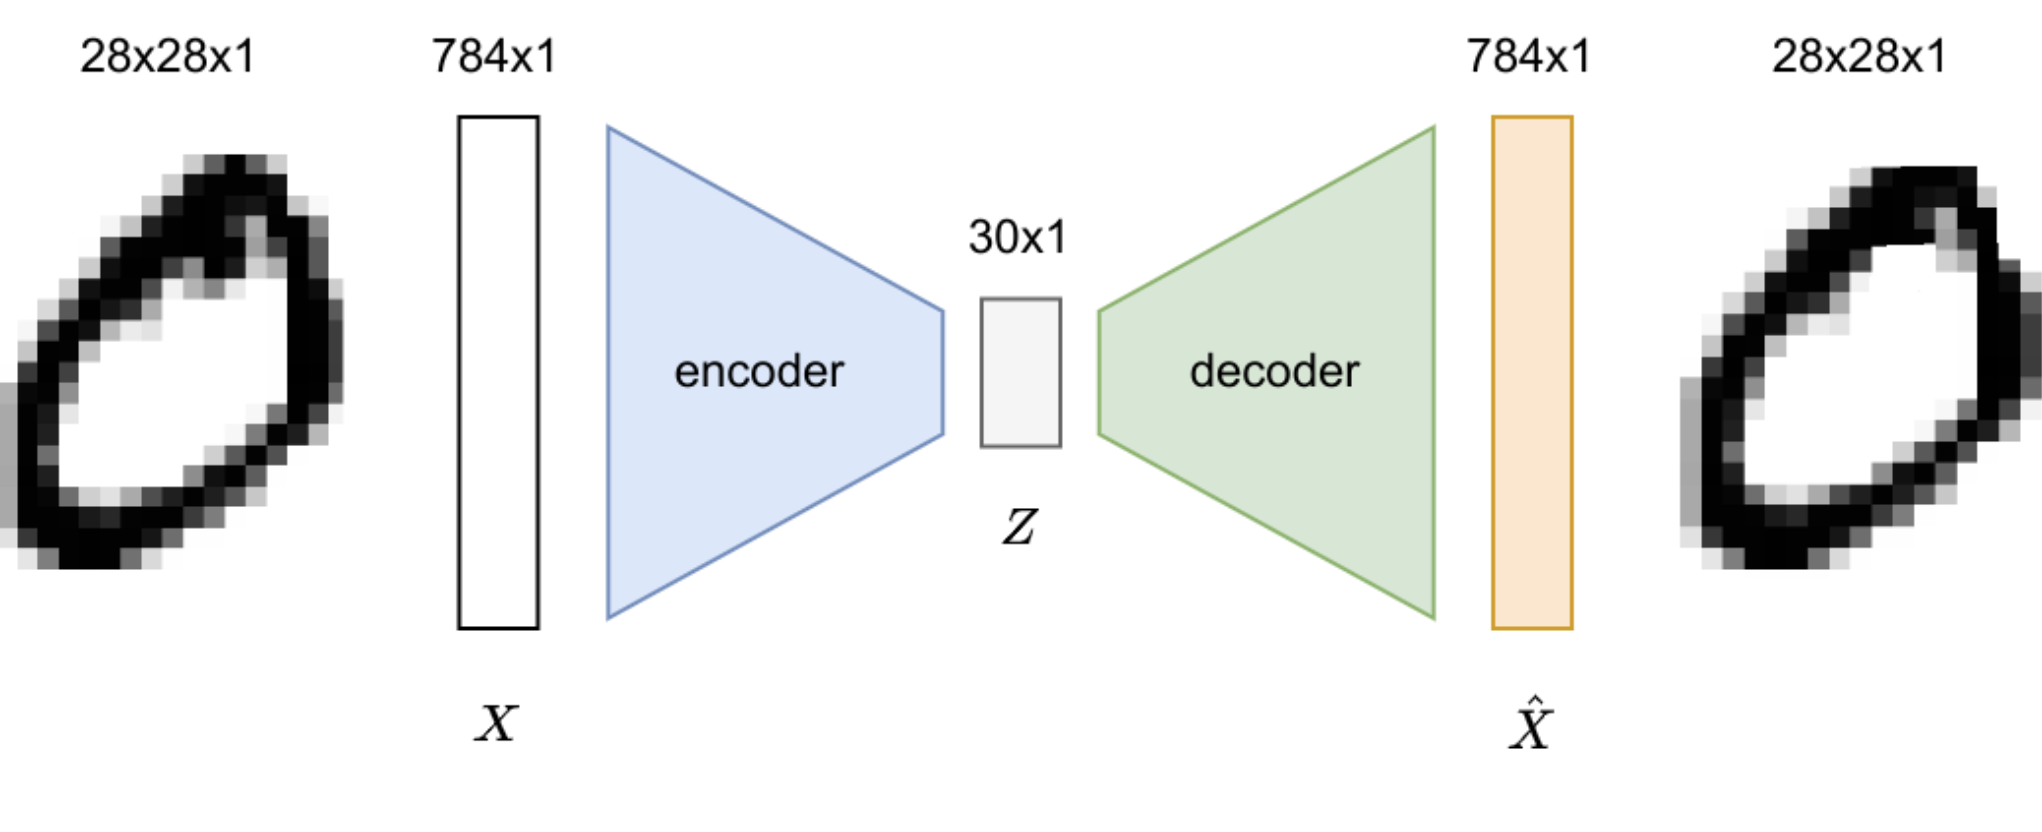


More sophisticated example with convolutional layers 

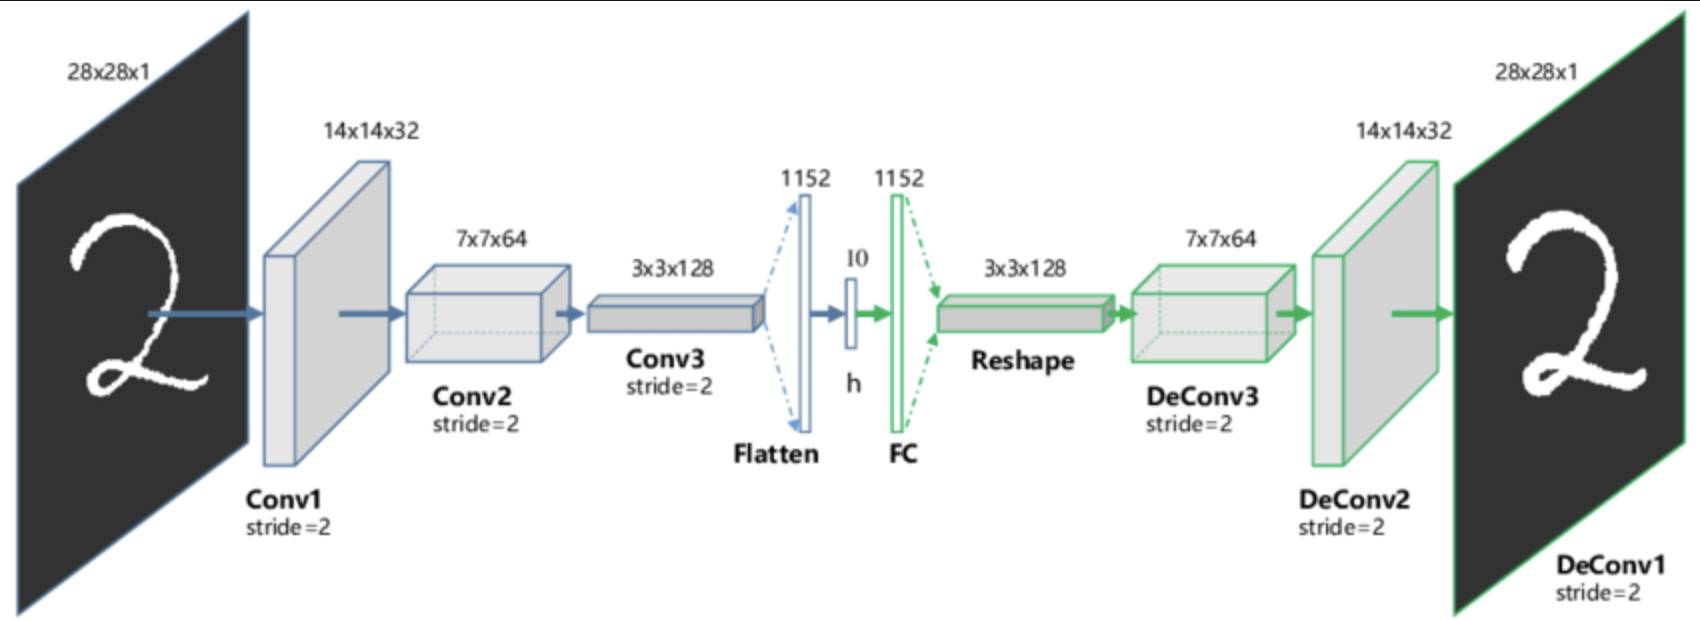

In [1]:
# let's use needed libraries 

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from time import time

If we are using Linux or Windows, CUDA could be aplied. 
If we are using Mac, we can use MPS (CUDA analougue to use GPU)

In [2]:
# CUDA
# torch.cuda.is_available()

False

In [5]:
# MPS
torch.backends.mps.is_available()

True

In [2]:
# setting default theme

def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

# converting vector to image

def to_img(y):
    """Convert vector to image"""
    y = 0.5 * (y + 1)
    y = y.view(y.size(0), 28, 28)
    return y


# displaying the image 

def display_images(in_, out, n=1):
    """Displaying routine"""
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(12, 4))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(12, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [3]:
set_default(figsize=(12, 3))

In [4]:
# Set random seeds dependant on the dievice in use
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.mps.manual_seed(42)

<a name="load_data"></a>
## Data load

Pytorch classes for effective data load:

* Dataset - address data paths and how to load them
* Dataloader - helps create batches for model input and shuffles data on each pass.

By default, values are in the range [0, 1], and we transform them into the range [-1, 1] to make it easier for the networks to learn.

In [7]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

## AutoEncoder

<a name="ae_code"></a>

Let's define the model architecture, the loss function (reconstruction loss), and the optimizer

In [8]:
# to use GPU device instead of default CPU

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")
    print("using mps")

using mps


In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

cpu


By commenting out lines with 'd', we can switch between a standard and denoising autoencoder. The key is not to forget to update the optimizer with the modified parameters after changing the dimensionality of the hidden layer.

In [11]:
# n = 28 x 28 = 784
d = 30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, y):
        h = self.encoder(y)
        y_tilda = self.decoder(h)
        return y_tilda

ae = Autoencoder().to(device)
criterion = nn.MSELoss()

In [12]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    ae.parameters(),
    lr=learning_rate,
)

<a name="ae_train"></a>
### Autoencoder Training Loop

* Pass the image through our model.
* Calculate the loss function value.
* Compute the partial derivatives of the loss function with respect to the model parameters (gradient).
* Take a step in the opposite direction.

At the end of each epoch, visualize the model output to observe how it learns over epochs.

epoch [1/20], loss:0.2059, elapsed: 6.3s
epoch [2/20], loss:0.1469, elapsed: 4.5s
epoch [3/20], loss:0.1233, elapsed: 4.5s
epoch [4/20], loss:0.1008, elapsed: 4.5s
epoch [5/20], loss:0.0985, elapsed: 4.5s
epoch [6/20], loss:0.0904, elapsed: 4.4s
epoch [7/20], loss:0.0877, elapsed: 4.5s
epoch [8/20], loss:0.0748, elapsed: 4.5s
epoch [9/20], loss:0.0792, elapsed: 4.5s
epoch [10/20], loss:0.0709, elapsed: 4.5s
epoch [11/20], loss:0.0771, elapsed: 4.4s
epoch [12/20], loss:0.0734, elapsed: 4.5s
epoch [13/20], loss:0.0634, elapsed: 4.5s
epoch [14/20], loss:0.0682, elapsed: 4.5s
epoch [15/20], loss:0.0686, elapsed: 4.6s
epoch [16/20], loss:0.0642, elapsed: 4.5s
epoch [17/20], loss:0.0631, elapsed: 4.5s
epoch [18/20], loss:0.0592, elapsed: 4.5s
epoch [19/20], loss:0.0594, elapsed: 4.5s
epoch [20/20], loss:0.0544, elapsed: 4.5s


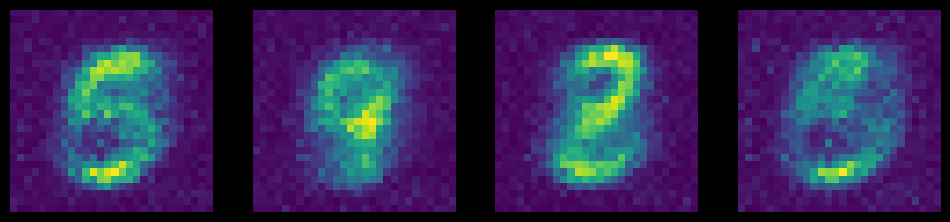

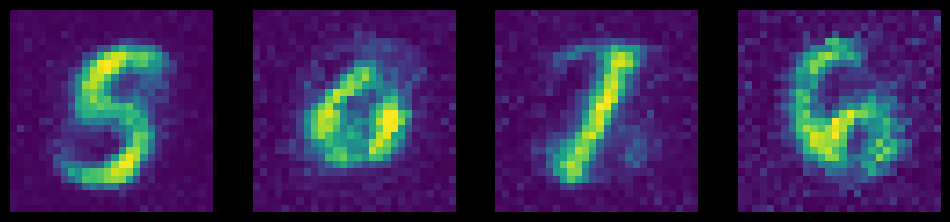

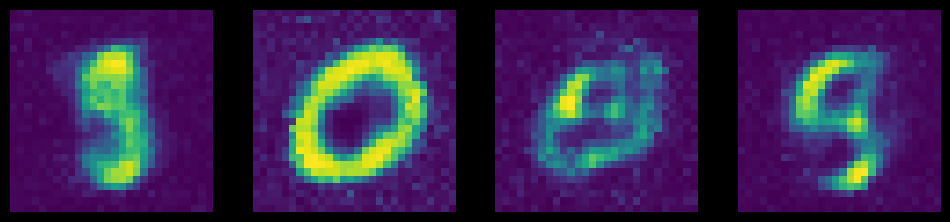

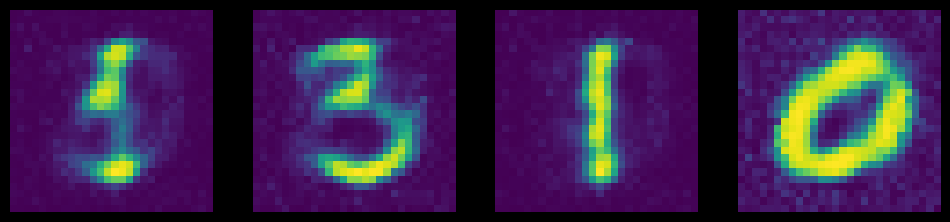

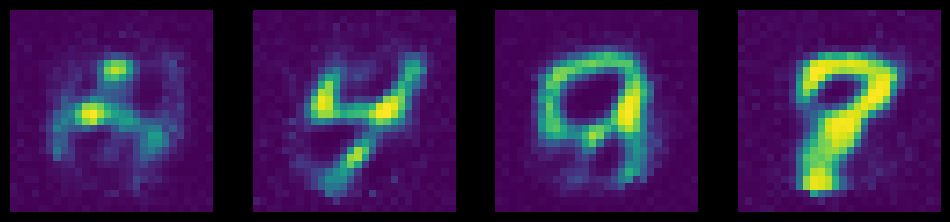

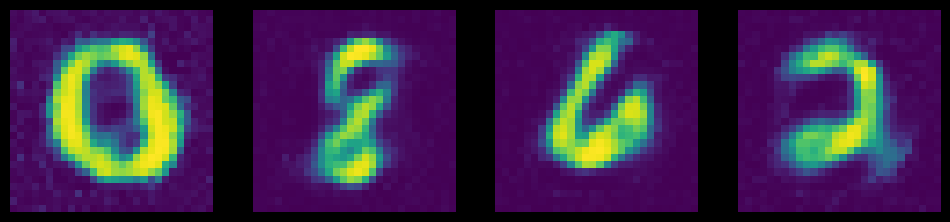

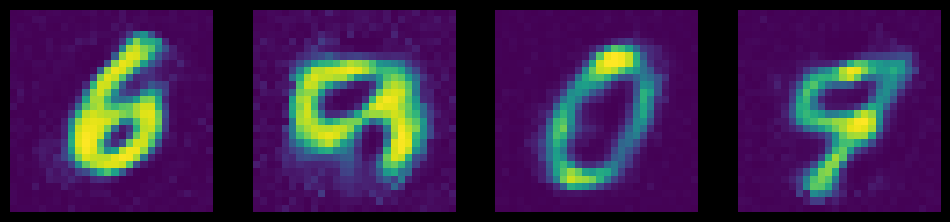

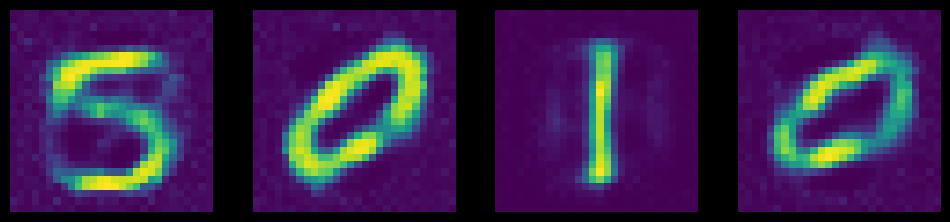

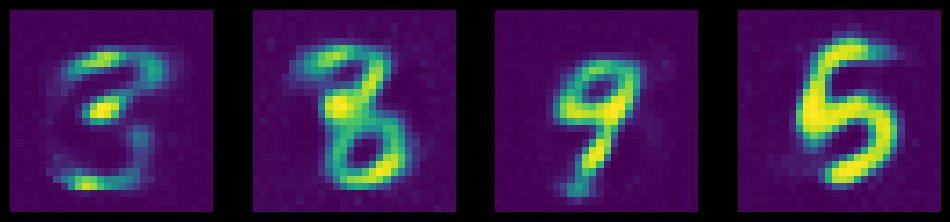

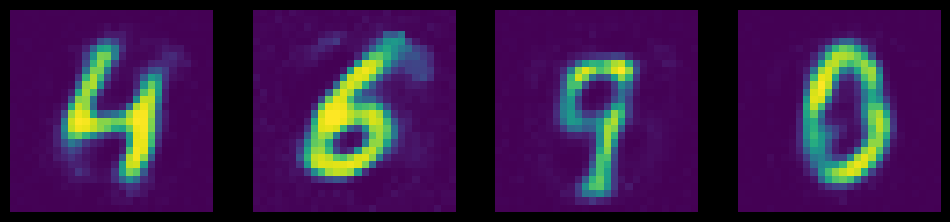

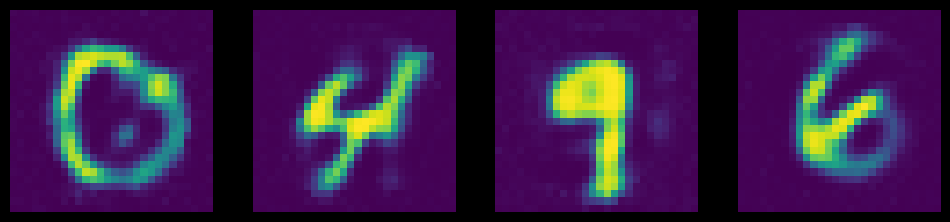

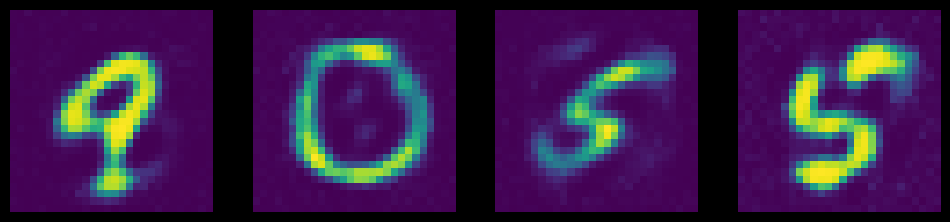

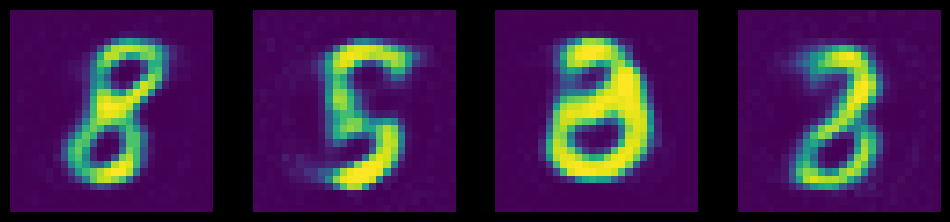

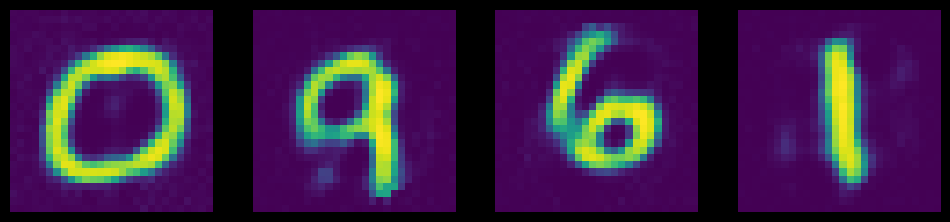

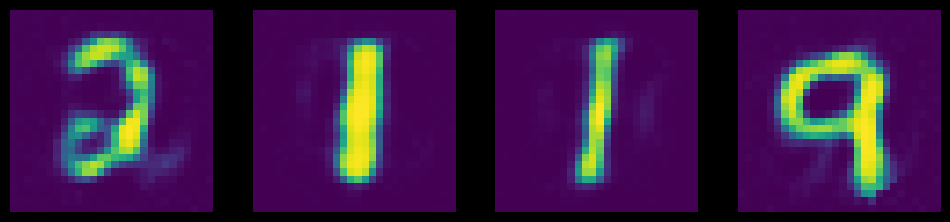

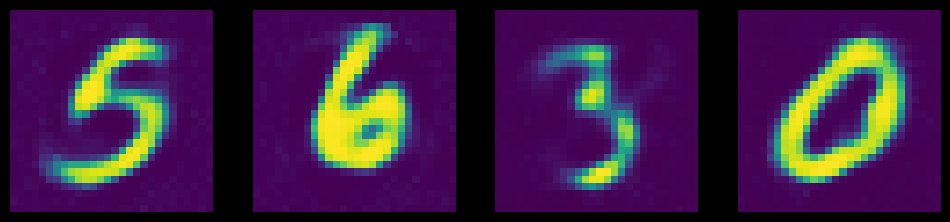

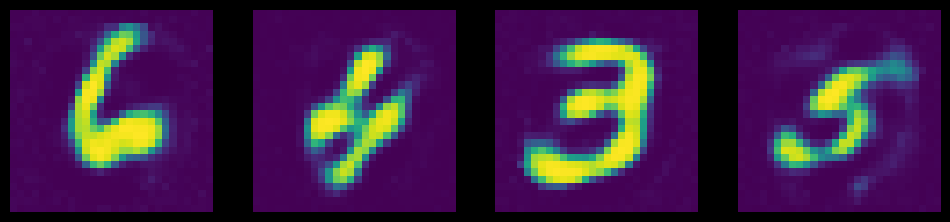

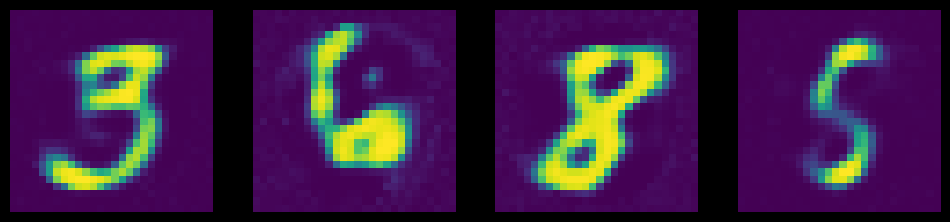

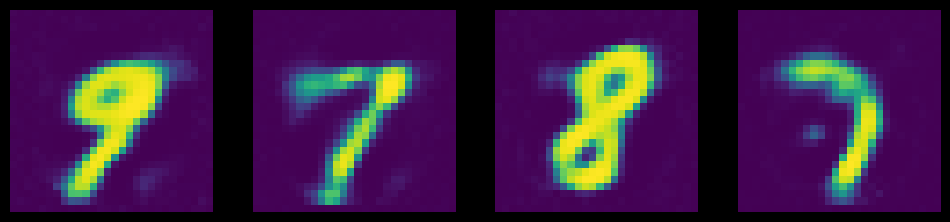

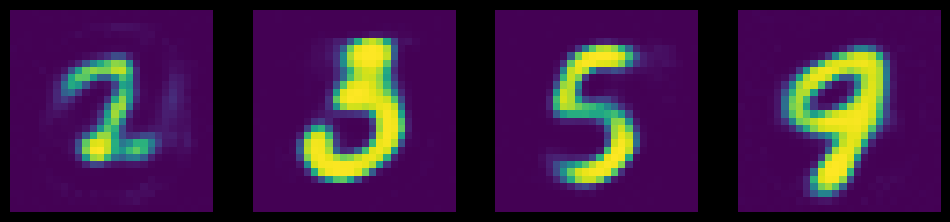

In [13]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    t0 = time()
    for data in dataloader:
        img, _ = data  # we don't need class labels
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = ae(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}, elapsed: {time() - t0:.1f}s')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

<a name="viz_ae_weights"></a>
### Visualization of "Kernels" (Encoder Weights)

Let's take a look at the first 8 kernels (there are a total of d).

We can see characteristic patterns in the center (purple color represents -1, yellow color represents 1), where digits are typically located. Around these patterns, there is random noise that averages to 0 in the background areas of the images. This means the model has understood that there is no useful information at the edges of the images.

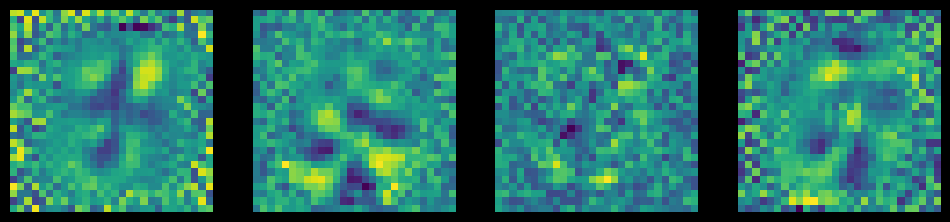

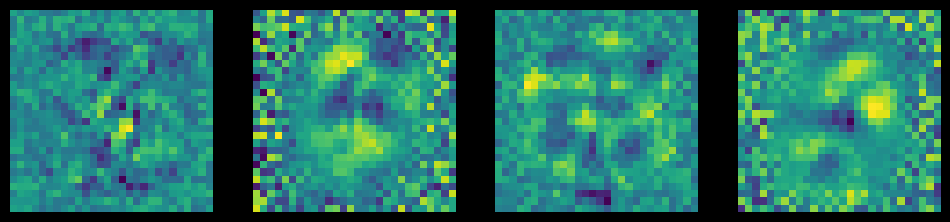

In [14]:
display_images(None, ae.encoder[0].weight, 2)

<a name="ae_train"></a>

### Generating from Random Vectors

Let's try generating images from randomly sampled vectors.

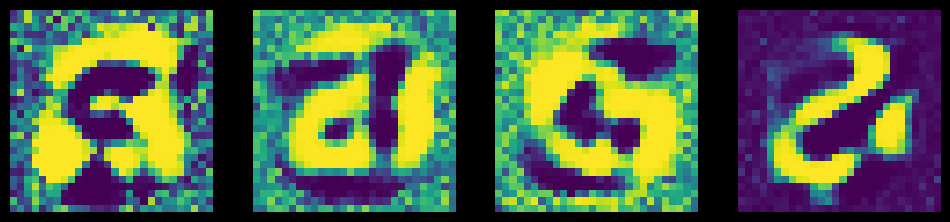

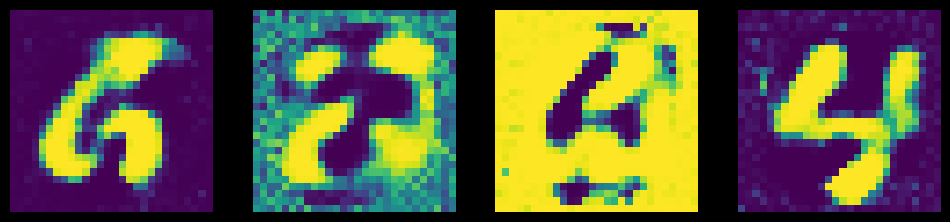

In [15]:
display_images(None, ae.decoder(torch.randn(8, d).to(device)), 2)

It may seem like nonsense, but we didn't aim to learn a beautiful data representation. The model has only learned what it was trained on, and for examples from the training set, there are compact representations in certain areas of the latent space, while the rest of the space remains unused.

This autoencoder property was often used in the past for anomaly detection and outlier detection in complex spaces, such as telemetry data from a large number of sensors. We pass a sample through the model, and if the resulting representation vector is far from the representations of the training set in the latent space, it's an atypical sample that can be further analyzed.

To obtain a good representation, you need to add components to the loss function that encourage mapping to a compact subregion of the latent space. We'll revisit this later.

## Denoising AutoEncoder

Let's change the dimensionality of the latent space from 30 to 500

In [19]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
# d = 30  # for standard AE (under-complete hidden layer)
d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, y):
        h = self.encoder(y)
        y_tilda = self.decoder(h)
        return y_tilda

dae = Autoencoder().to(device)
criterion = nn.MSELoss()

In [20]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    dae.parameters(),
    lr=learning_rate,
)

<a name="dae_train"></a>

### Denoising Autoencoder Training Loop
* Add a noise vector that will zero out 50% of the pixels in the input image.
* Input the noisy image and obtain the original image as the output.

epoch [1/20], loss:0.0753, elapsed: 5.7s
epoch [2/20], loss:0.0574, elapsed: 5.0s
epoch [3/20], loss:0.0538, elapsed: 5.0s
epoch [4/20], loss:0.0459, elapsed: 5.1s
epoch [5/20], loss:0.0490, elapsed: 5.0s
epoch [6/20], loss:0.0461, elapsed: 5.0s
epoch [7/20], loss:0.0461, elapsed: 5.0s
epoch [8/20], loss:0.0456, elapsed: 5.0s
epoch [9/20], loss:0.0478, elapsed: 5.0s
epoch [10/20], loss:0.0448, elapsed: 5.0s
epoch [11/20], loss:0.0468, elapsed: 5.0s


/var/folders/lm/jstl07v96jgg_zyfm1kf06ch0000gn/T/ipykernel_48992/875008544.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 4))


epoch [12/20], loss:0.0426, elapsed: 5.0s
epoch [13/20], loss:0.0425, elapsed: 5.0s
epoch [14/20], loss:0.0426, elapsed: 5.0s
epoch [15/20], loss:0.0426, elapsed: 5.0s
epoch [16/20], loss:0.0423, elapsed: 5.2s
epoch [17/20], loss:0.0406, elapsed: 5.0s
epoch [18/20], loss:0.0438, elapsed: 5.0s
epoch [19/20], loss:0.0423, elapsed: 5.0s
epoch [20/20], loss:0.0393, elapsed: 5.0s


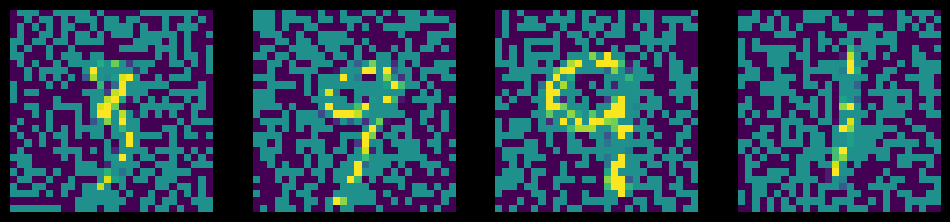

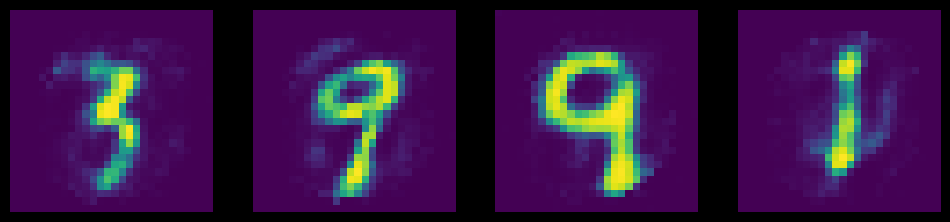

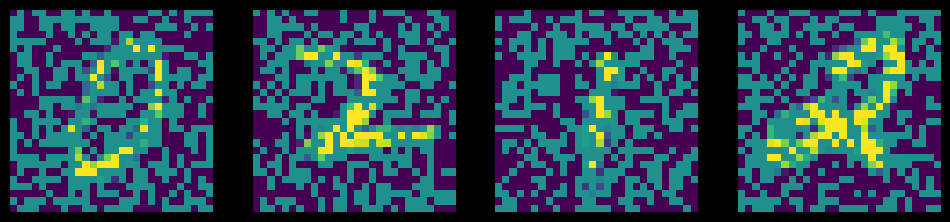

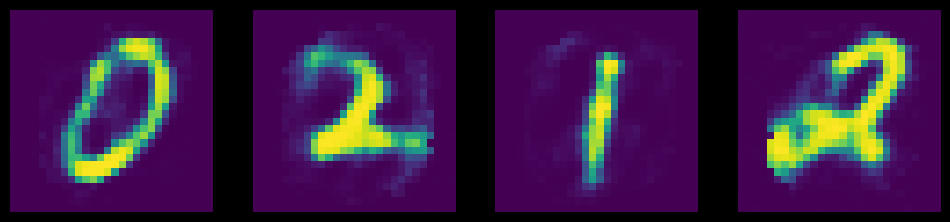

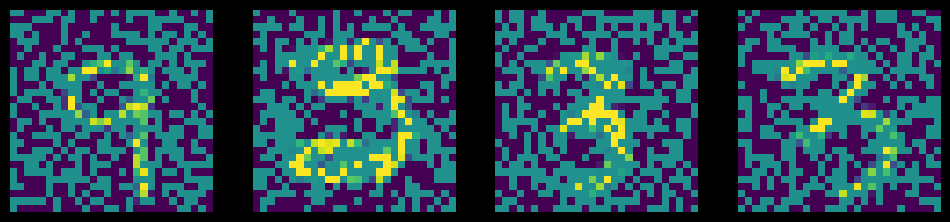

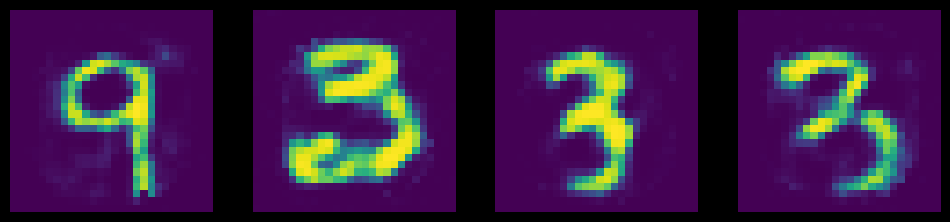

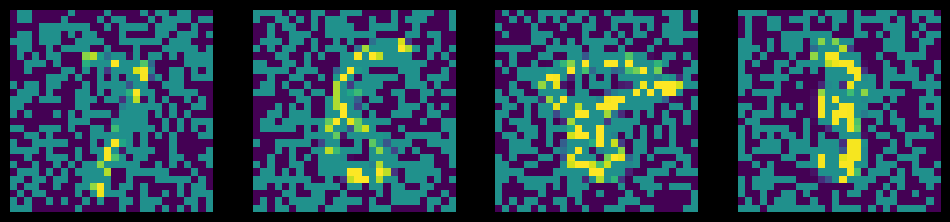

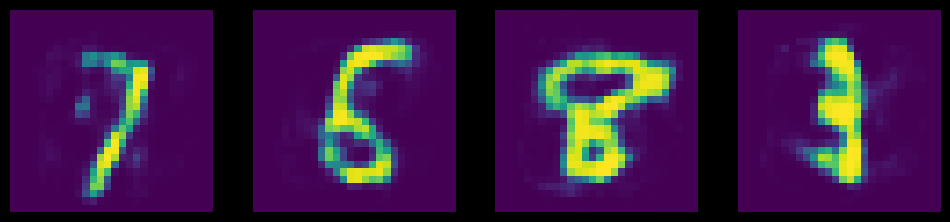

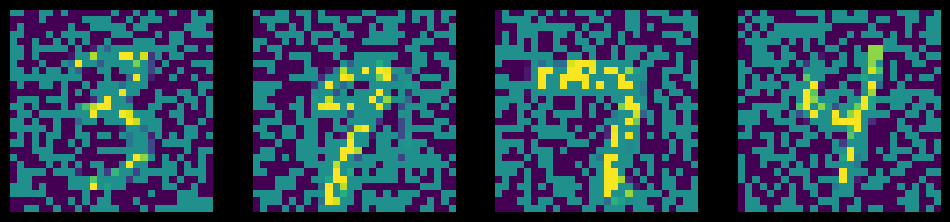

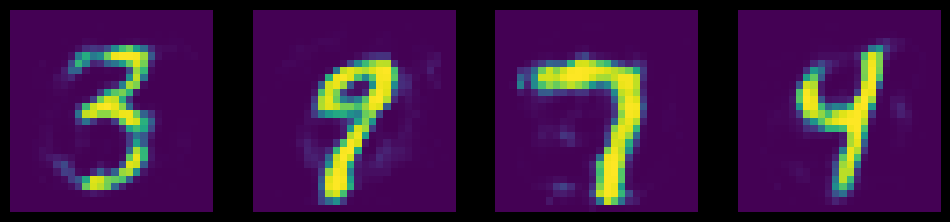

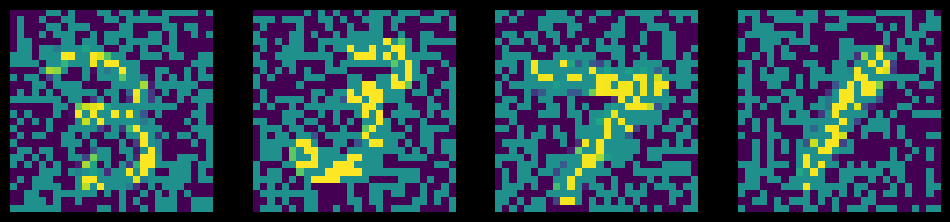

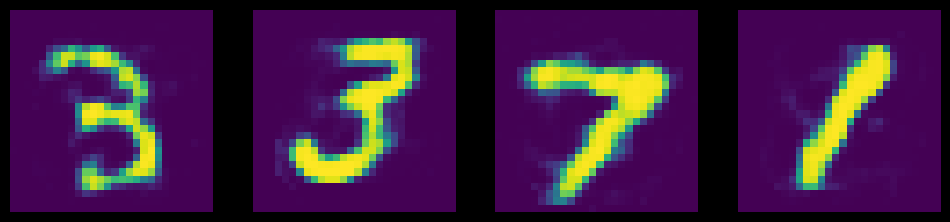

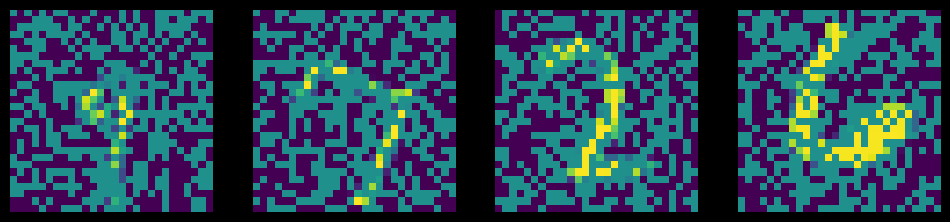

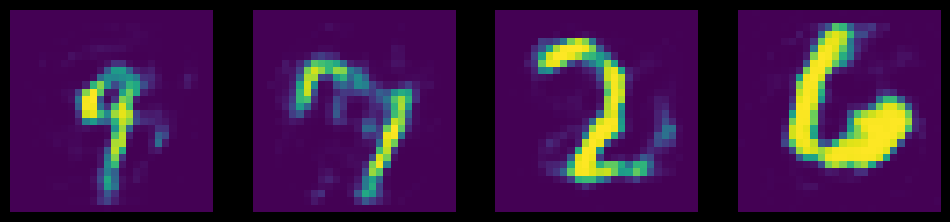

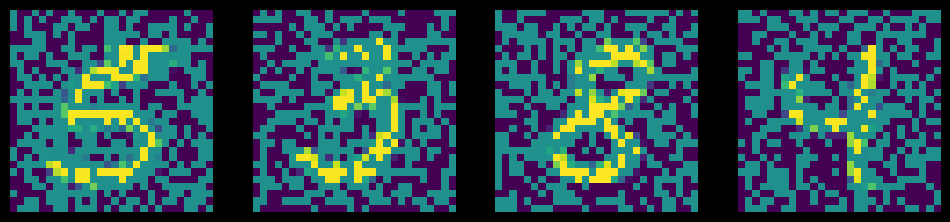

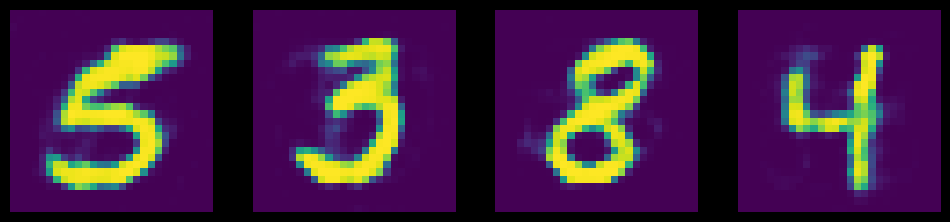

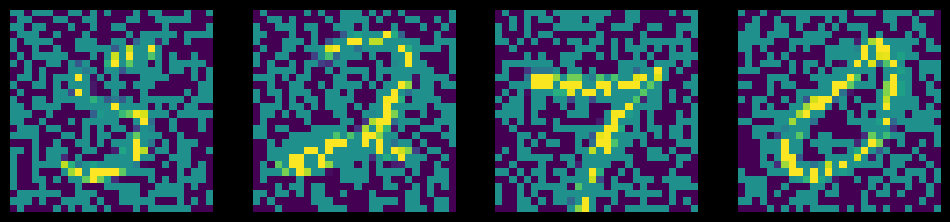

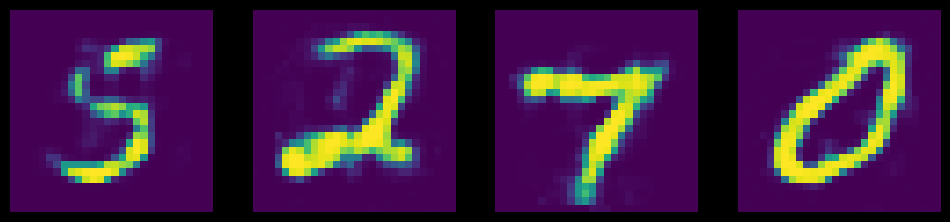

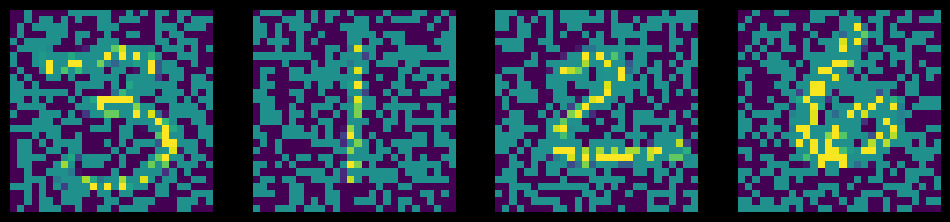

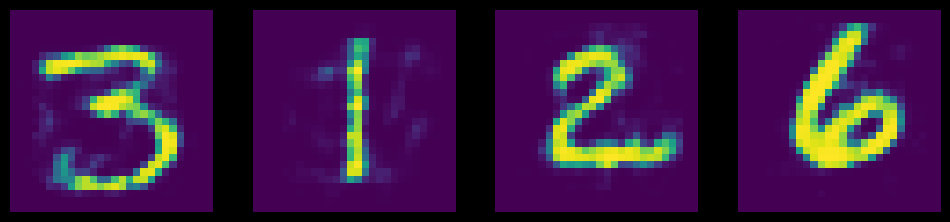

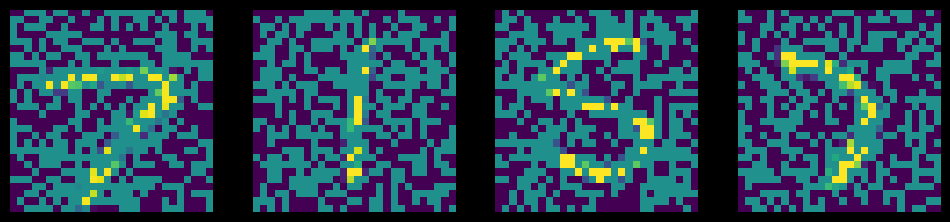

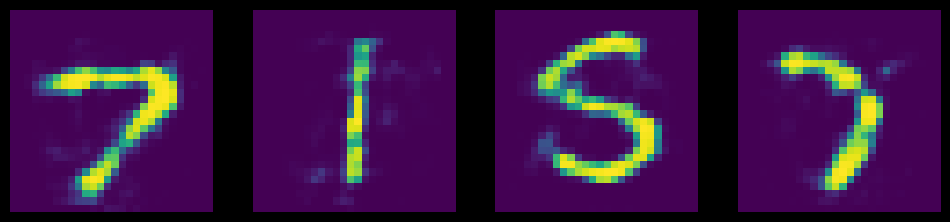

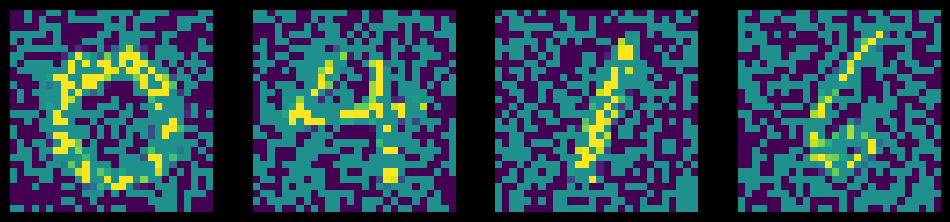

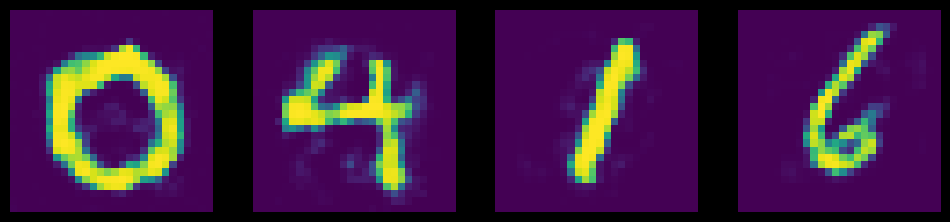

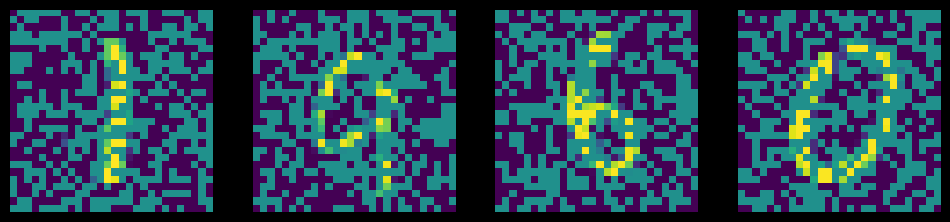

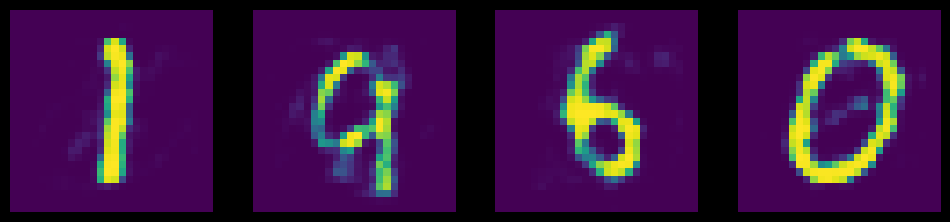

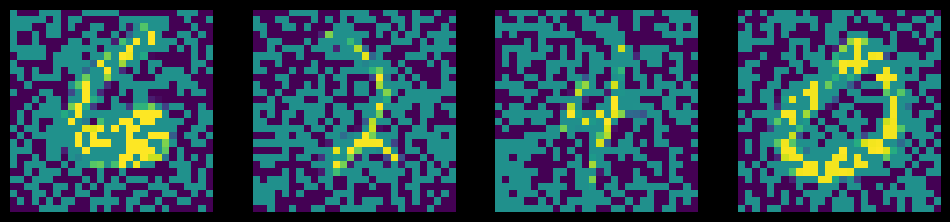

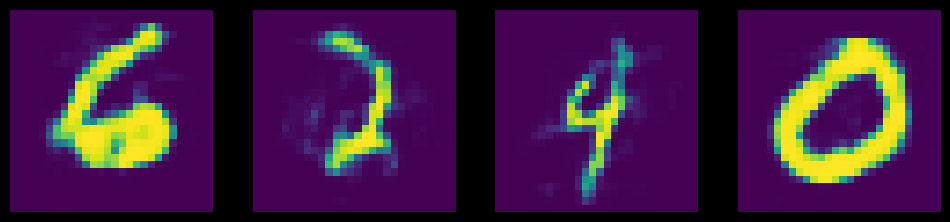

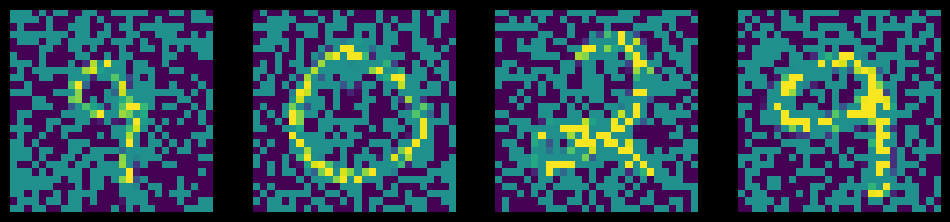

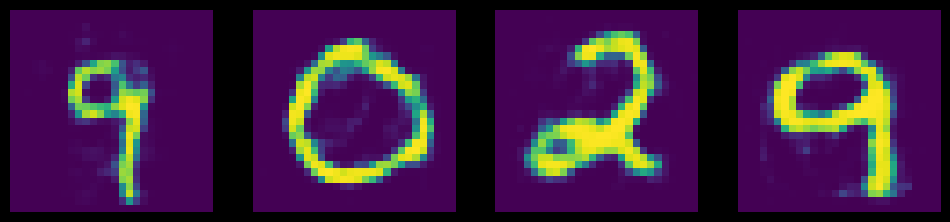

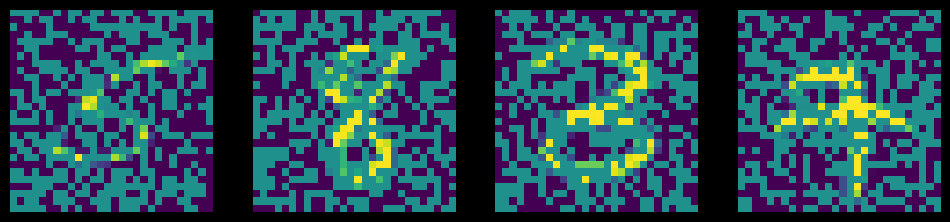

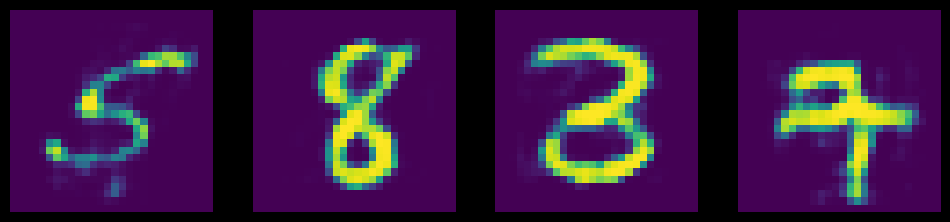

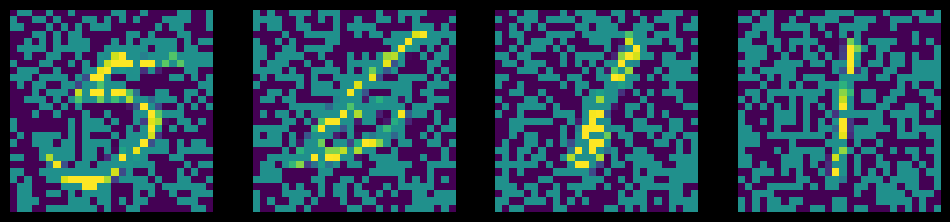

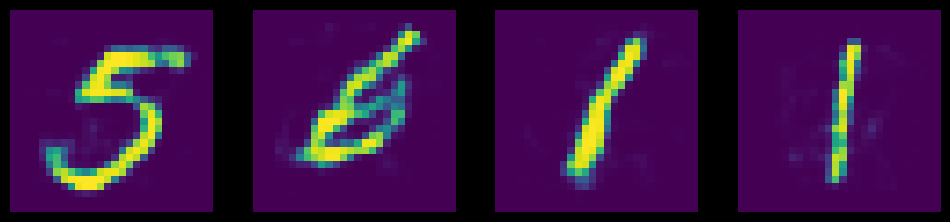

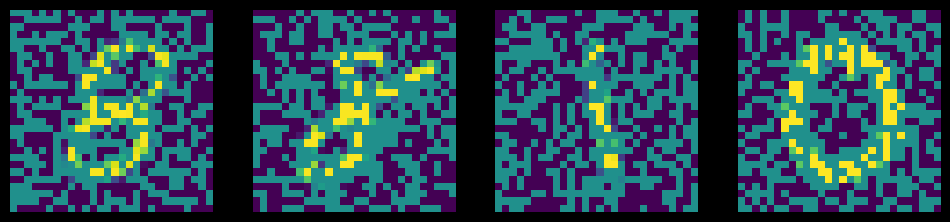

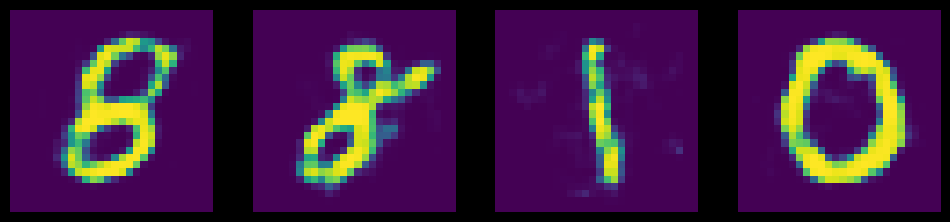

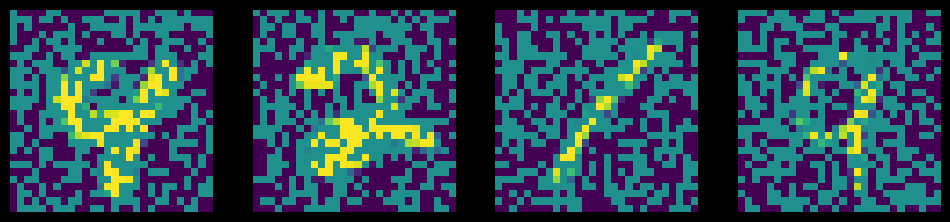

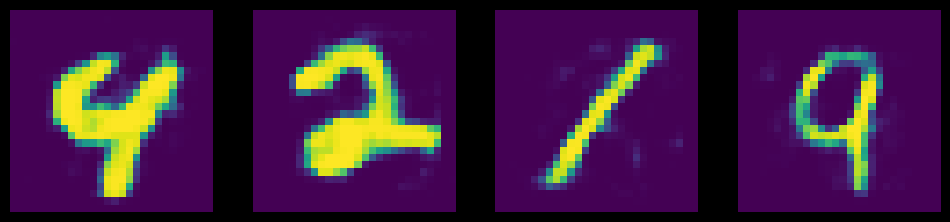

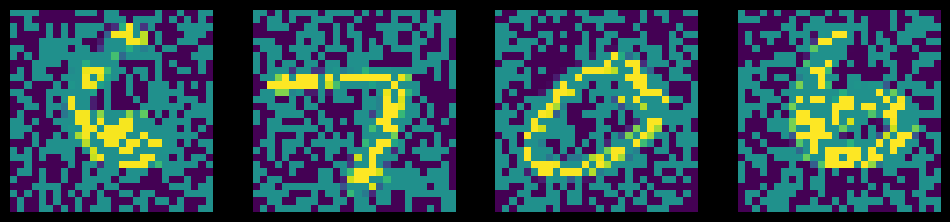

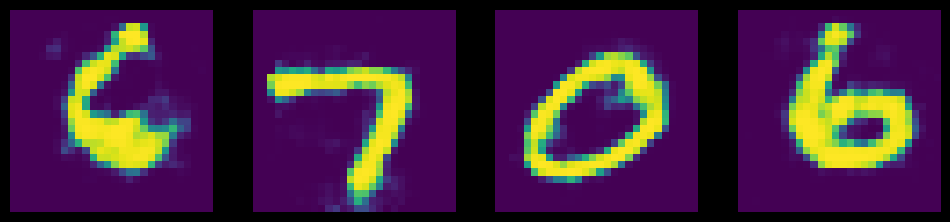

In [21]:
num_epochs = 20
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    t0 = time()
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = dae(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}, elapsed: {time() - t0:.1f}s')
    display_images(img_bad, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

### Visualization of 'Kernels' (Encoder Weights)

Characteristic patterns in the center remain, but instead of random noise, there are zeros around them. In other words, the model has understood that only noise is present at the edges of the noisy images, which needs to be eliminated.

The exception is kernels that consist entirely of noise. These kernels haven't learned anything, and there are more of them here than in a regular AE because the dimensionality of the latent space is higher. You can try reducing the dimensionality

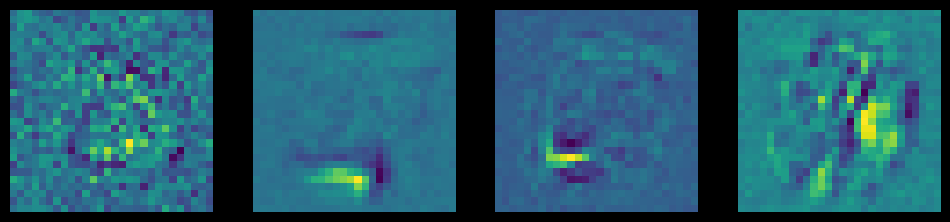

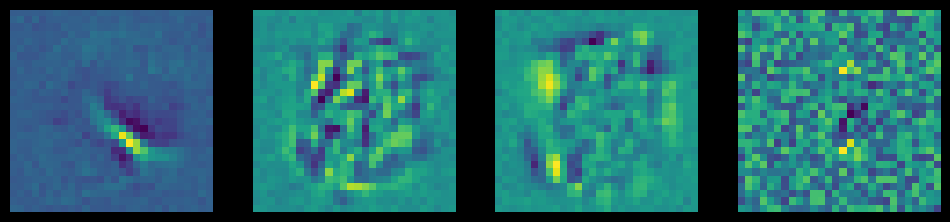

In [22]:
display_images(None, dae.encoder[0].weight, 2)

<a name="ae_interp"></a>
### Interpolation of images

Let's try calculating the arithmetic mean of two images and input it into the model. We can see that at the input, there's something average, but at the output, the model has attempted to reconstruct a digit, but the result is somewhat suboptimal. This is precisely the property of autoencoder representations we discussed earlier, where it is defined only for certain regions of the space

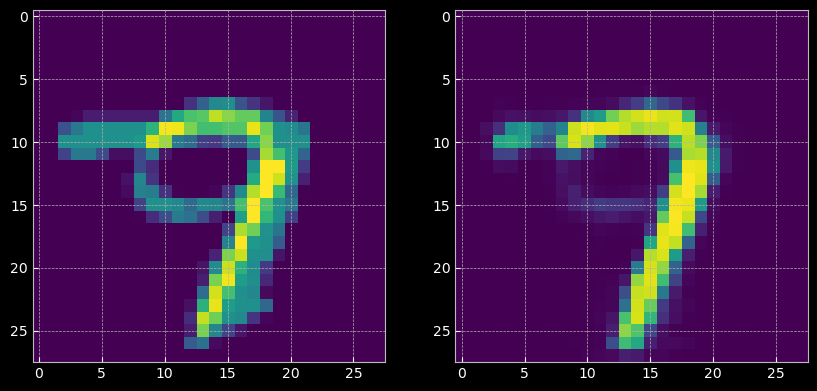

In [23]:
y = (img[1:2] + img[15:16])/2
with torch.no_grad():
    y_tilda = dae(y)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(to_img(y.cpu()).squeeze())
plt.subplot(122)
plt.imshow(to_img(y_tilda.cpu()).squeeze());

<a name="vae_code"></a>
## Variational AE (VAE)

Let's load data from the beggining and will not transform it into the [-1, 1].

In [13]:
# TODO: Сделать единую функцию display_images

def display_images(in_, out, n=1, label='', count=False, energy=None):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(12, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(12, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            c = 4 * N + i
            if count: plt.title(str(c), color='w')
            if count and energy is not None: plt.title(f'{c}, e={energy[c].item():.2f}', color='w')

In [14]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [15]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

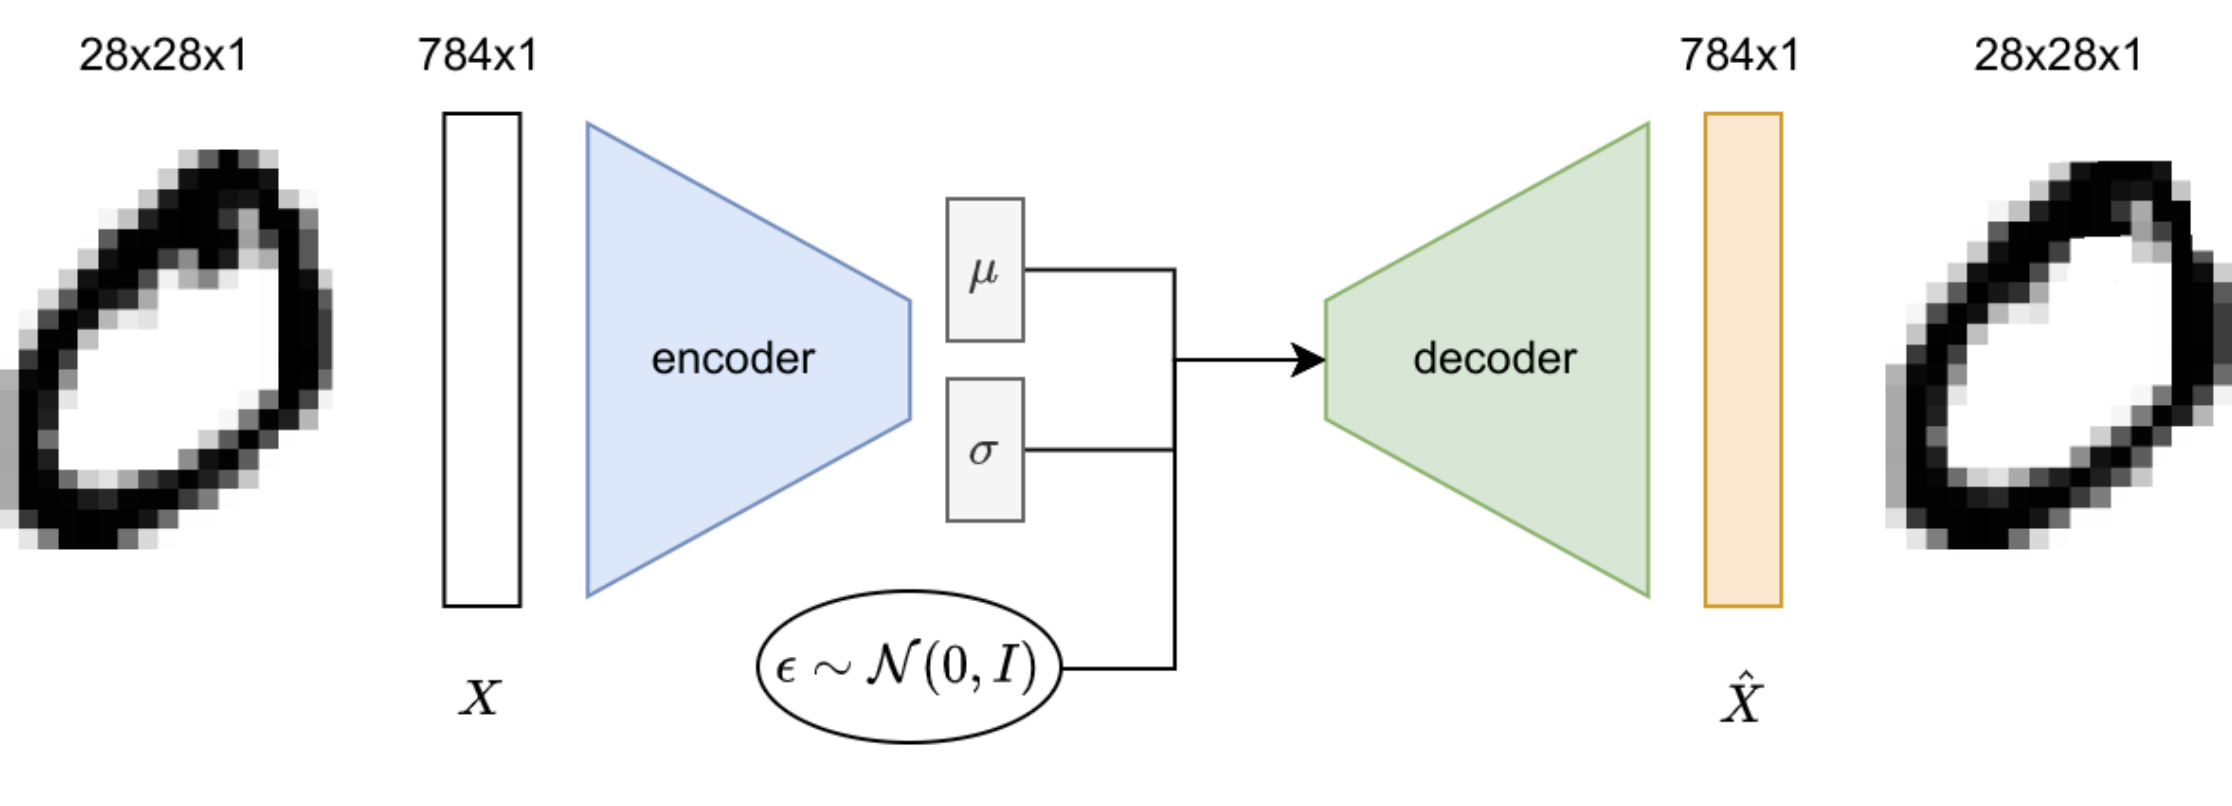

VAE architecture is almost identical to AE, except the fact that instead of mapping the input data to a vector, we map it to a multi-dimensional normal distribution. The vector output of the encoder is then replaced by two vectors, one of which corresponds to the mean, and the other to the standard deviation of this distribution. Then, in order to obtain an image, we can sample a vector from this distribution and pass it through the decoder 

Decoder architecture didn't change.

There is one issue here because in the middle of the network, there is a sampling operation through which gradients cannot pass. However, we need to train the entire network from start to finish.

To solve this problem, we apply the 'reparametrization trick,' where a random vector is represented as $x = \mu + \sigma*\epsilon$, where $\epsilon \in \mathcal{N}(0, 1)$. Then, we train $\mu$ and $\sigma$, while $\epsilon$ doesn't matter; it's just a sample from a standard normal distribution. In other words, instead of having a random node in the network through which gradients cannot pass, we split it into parts - one through which gradients can pass (μ and σ), and the other remains random, but we don't want to train it because it's fixed for us.

Instead of using the regular standard deviation (SD), we work with the logarithm of the variance, which is later transformed into SD as `torch.exp(0.5*logvar)`. This is simply a scaling change of variance (which is positive) along the entire real axis and stretching small values around zero.

To reconstruct the image, we sample from the normal distribution to obtain the latent representation `z`, which is then sent to the decoder.

In [16]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, y):
        mu_logvar = self.encoder(y.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

vae = VAE().to(device)

In [17]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    vae.parameters(),
    lr=learning_rate,
)

We use a loss function that combines Binary Cross-Entropy (BCE) and Kullback-Leibler Divergence (KLD).

BCE is used to minimize the reconstruction error of the image by the encoder. If you wonder why we use BCE instead of, for example, Mean Squared Error (MSE), [you are not alone](https://stats.stackexchange.com/questions/370179/why-binary-crossentropy-can-be-used-as-the-loss-function-in-autoencoders).

TLDR: We want the output to be values between 0 and 1, so the decoder uses a sigmoid, which pairs well with the logarithm in BCE, as it helps avoid the plateau effect in gradients, typical for the sigmoid function.

$BCE(y,\hat y)=−y\cdot log(\hat y)−(1−y)\cdot log(1−\hat y)$

In this loss function, KL-divergence serves as a regularizer.

When comparing a normal distribution to a standard one, it is expressed as follows:

$D_{KL}(\mathcal{N}(\mu,\upsilon)\parallel \mathcal{N}(0,1))=\frac{1}{2}\displaystyle\sum_{i=1}^d\upsilon_i - log(\upsilon_i) - 1 + \mu_i^2$,

where $V=\upsilon_i - log(\upsilon_i) - 1$, and $U=\mu_i^2$ is minimized when the mean is a zero vector.

It is evident that the KLD component is minimized when the variance is 1, and the mean is a zero vector, meaning that the output distribution $\mathcal{N}(\mu,\upsilon)$ from the encoder is close to the standard normal.

Thus, this encourages embeddings in the latent space to be more compactly distributed.

In [18]:
def loss_function(y_tilda, y, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        y_tilda, y.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return BCE, KLD

### VAE Training Loop

* For the first epoch, skip training to calculate the test loss on an untrained network.
* Pass the input image through the model.
* Obtain the reconstructed image, mean, and logarithm of the variance.
* Calculate the loss function and take a step in the opposite direction of the gradient.

====> Test set loss BCE: 543.1704, KLD: 0.1243, total: 543.2947
====> Epoch: 1 Average loss BCE: 174.6839, KLD: 12.9896, total: 187.6735, elapsed: 4.0s
====> Test set loss BCE: 115.5666, KLD: 18.2988, total: 133.8654
====> Epoch: 2 Average loss BCE: 110.9936, KLD: 20.1963, total: 131.1899, elapsed: 3.6s
====> Test set loss BCE: 92.3532, KLD: 21.7833, total: 114.1366
====> Epoch: 3 Average loss BCE: 97.5278, KLD: 22.6172, total: 120.1451, elapsed: 3.6s
====> Test set loss BCE: 84.2421, KLD: 23.3813, total: 107.6234
====> Epoch: 4 Average loss BCE: 91.7088, KLD: 23.7244, total: 115.4332, elapsed: 3.7s
====> Test set loss BCE: 79.9053, KLD: 24.5586, total: 104.4639
====> Epoch: 5 Average loss BCE: 88.6006, KLD: 24.3015, total: 112.9021, elapsed: 3.6s
====> Test set loss BCE: 78.1030, KLD: 24.4363, total: 102.5393
====> Epoch: 6 Average loss BCE: 86.6066, KLD: 24.5625, total: 111.1691, elapsed: 3.8s
====> Test set loss BCE: 76.2037, KLD: 25.0631, total: 101.2668
====> Epoch: 7 Average loss

/var/folders/lm/jstl07v96jgg_zyfm1kf06ch0000gn/T/ipykernel_64889/2140893110.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 4))


====> Epoch: 11 Average loss BCE: 82.1754, KLD: 25.0927, total: 107.2682, elapsed: 3.7s
====> Test set loss BCE: 72.5284, KLD: 25.4834, total: 98.0118
====> Epoch: 12 Average loss BCE: 81.6728, KLD: 25.1367, total: 106.8095, elapsed: 3.7s
====> Test set loss BCE: 72.4306, KLD: 25.1085, total: 97.5391
====> Epoch: 13 Average loss BCE: 81.2518, KLD: 25.1598, total: 106.4116, elapsed: 3.8s
====> Test set loss BCE: 72.0737, KLD: 24.9487, total: 97.0223
====> Epoch: 14 Average loss BCE: 80.9137, KLD: 25.2172, total: 106.1309, elapsed: 3.8s
====> Test set loss BCE: 71.6166, KLD: 26.0925, total: 97.7091
====> Epoch: 15 Average loss BCE: 80.5495, KLD: 25.2094, total: 105.7589, elapsed: 3.6s
====> Test set loss BCE: 71.4383, KLD: 24.9908, total: 96.4291
====> Epoch: 16 Average loss BCE: 80.3106, KLD: 25.2574, total: 105.5680, elapsed: 3.8s
====> Test set loss BCE: 70.9768, KLD: 25.1025, total: 96.0793
====> Epoch: 17 Average loss BCE: 80.0338, KLD: 25.2770, total: 105.3108, elapsed: 3.7s
====> 

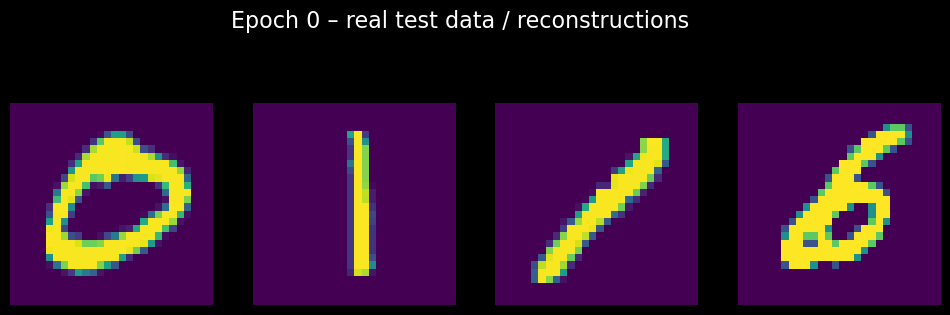

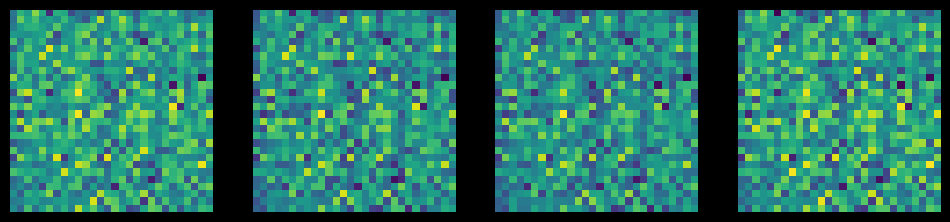

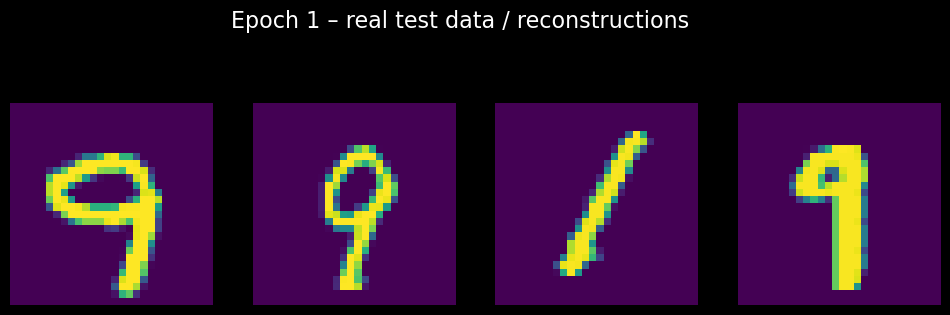

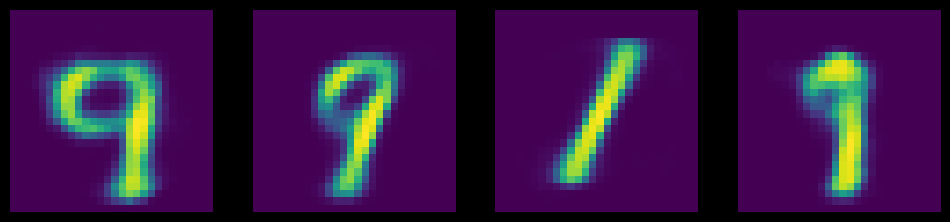

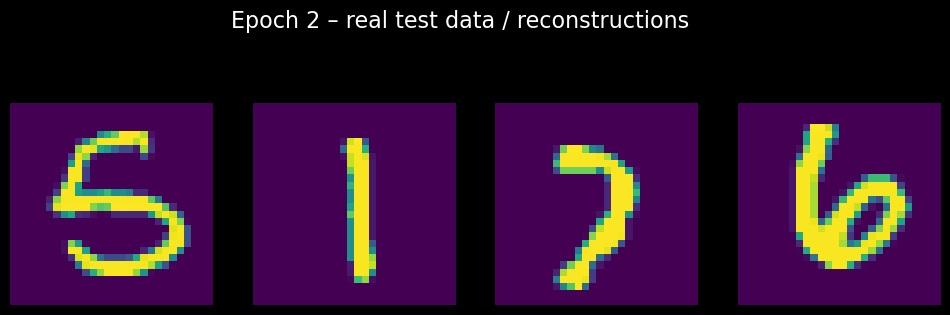

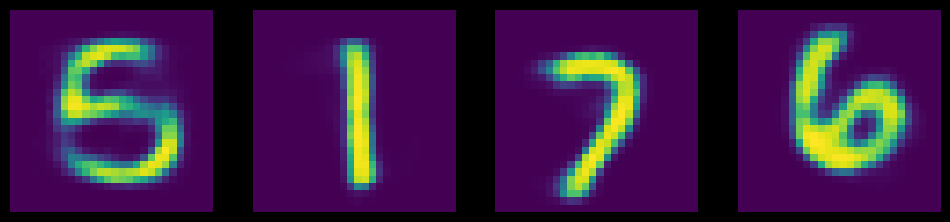

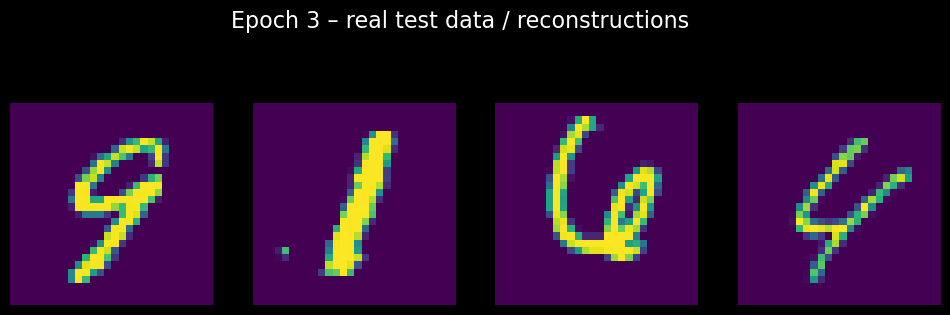

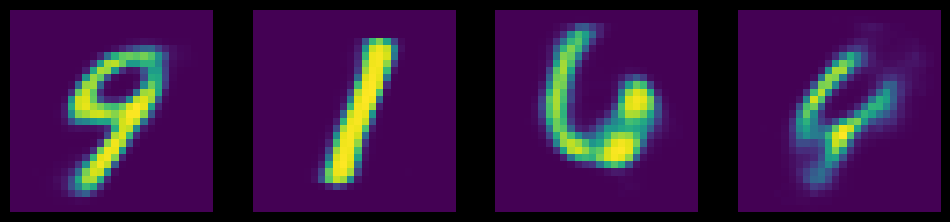

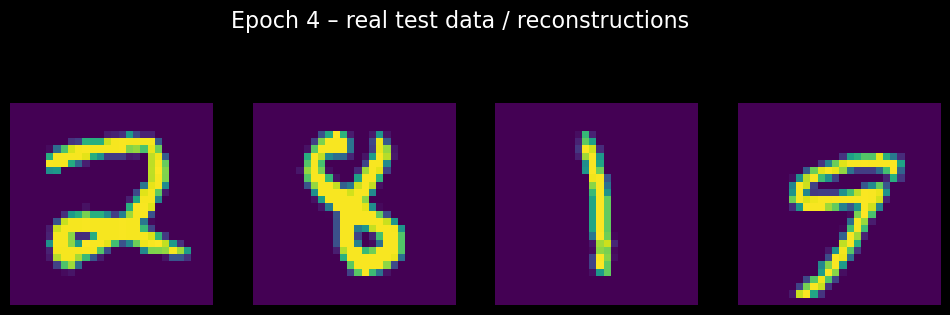

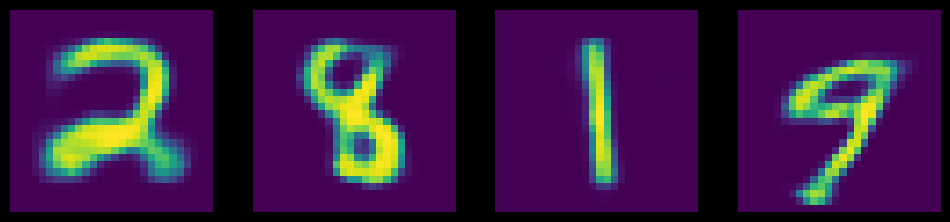

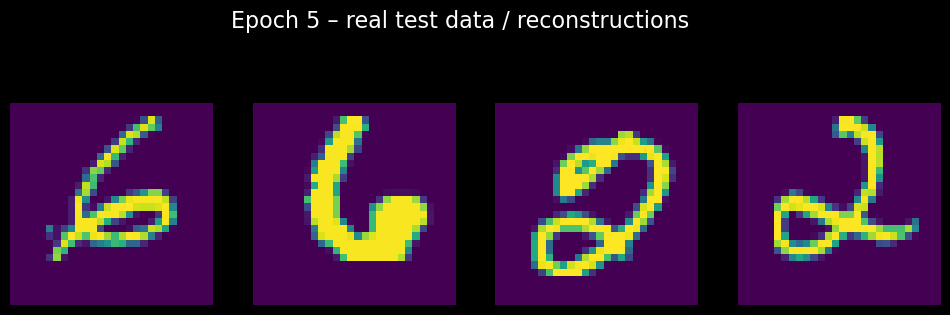

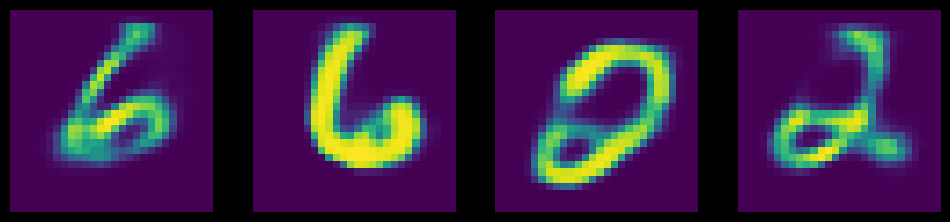

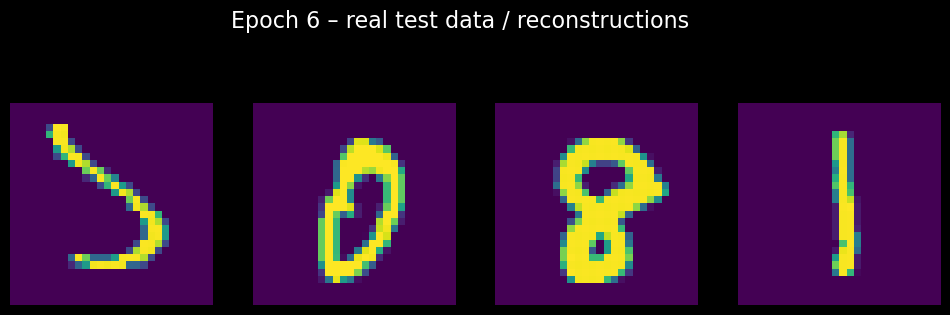

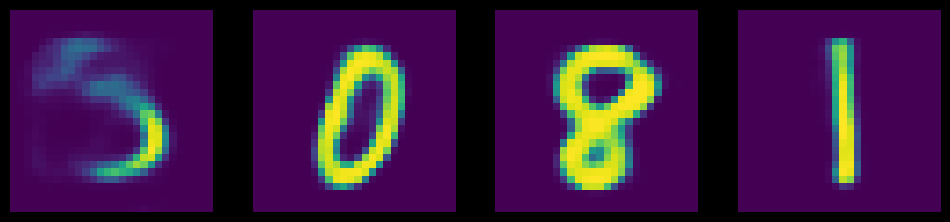

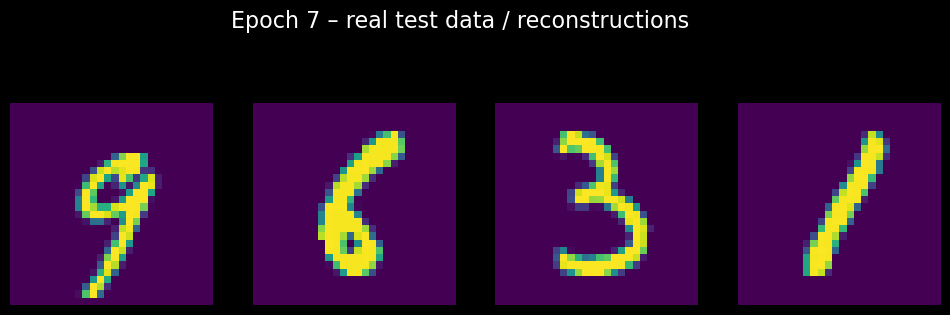

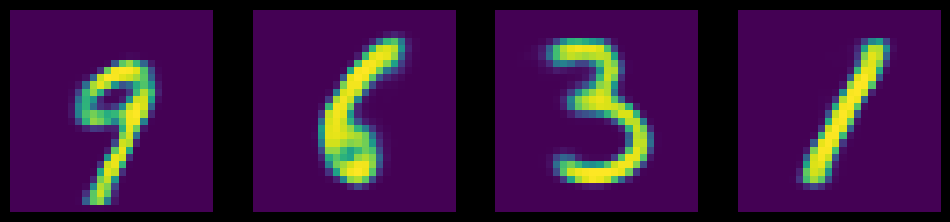

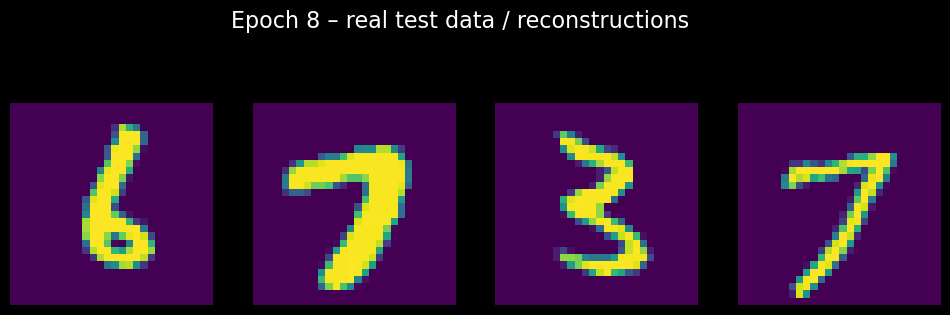

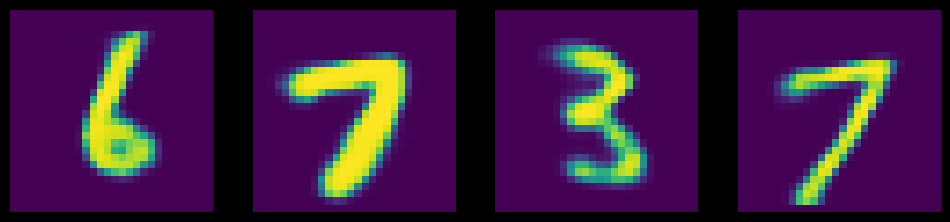

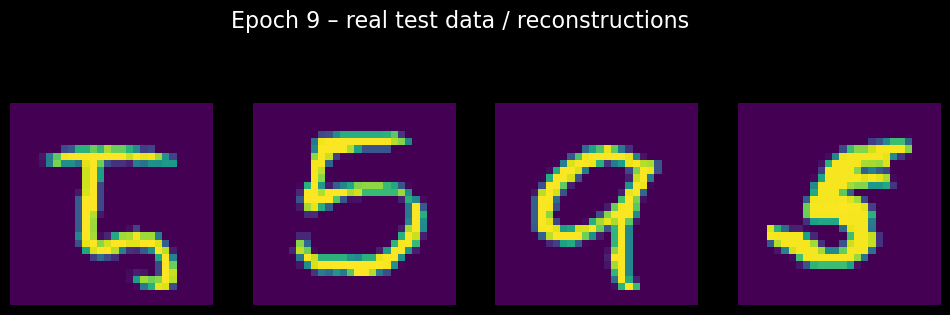

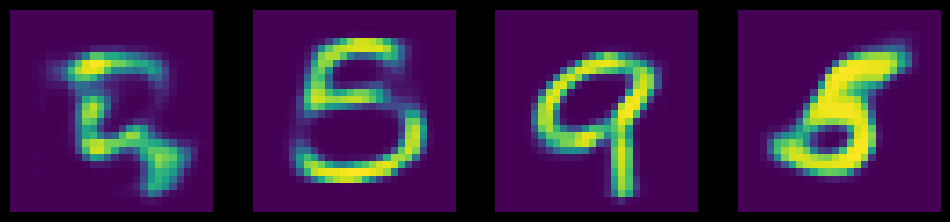

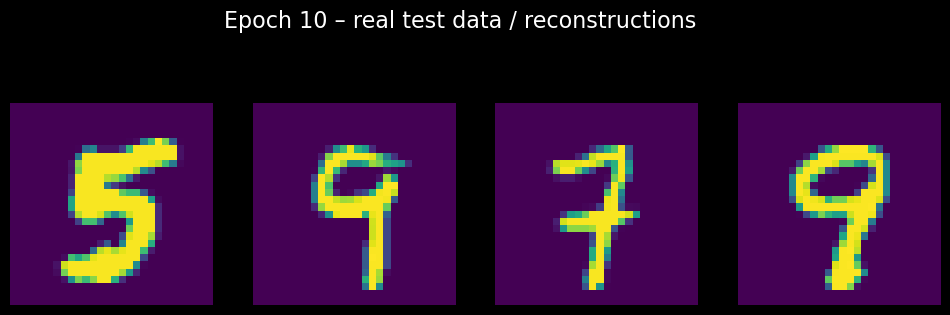

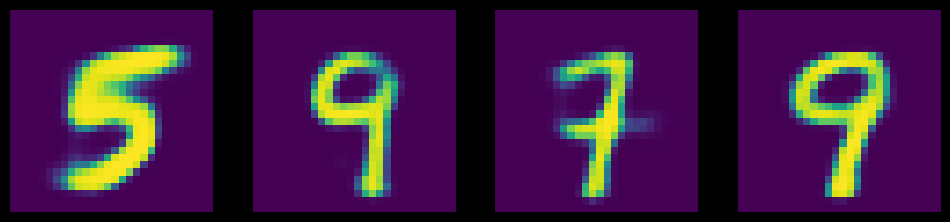

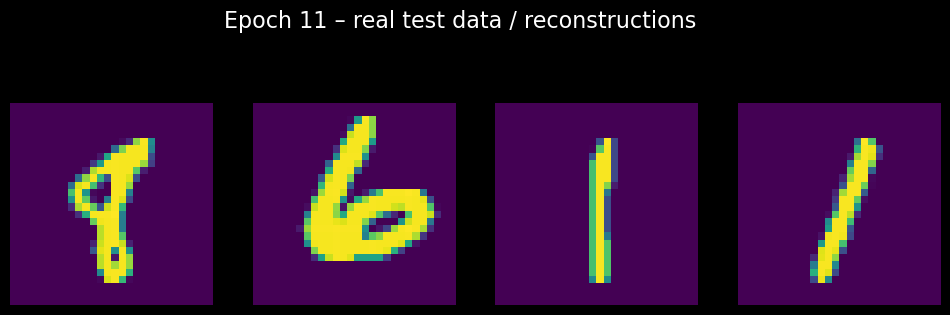

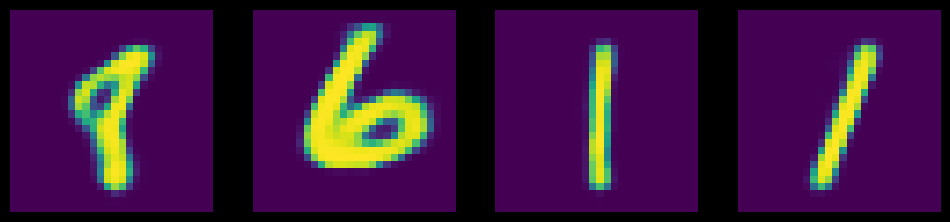

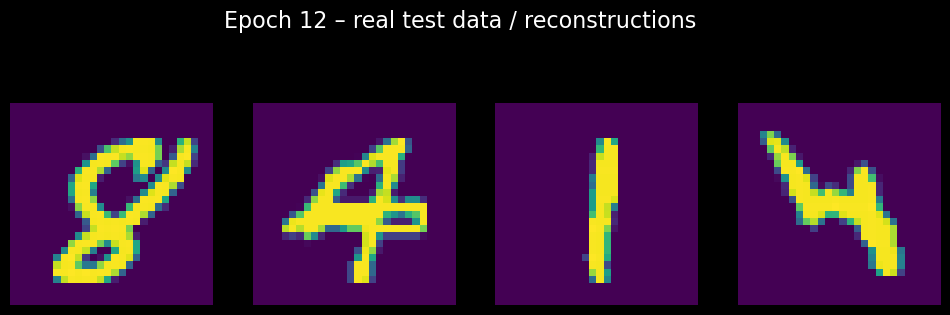

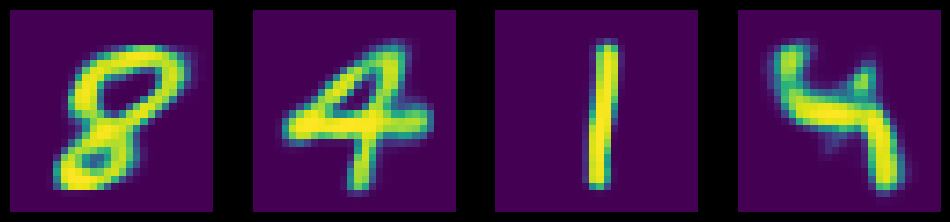

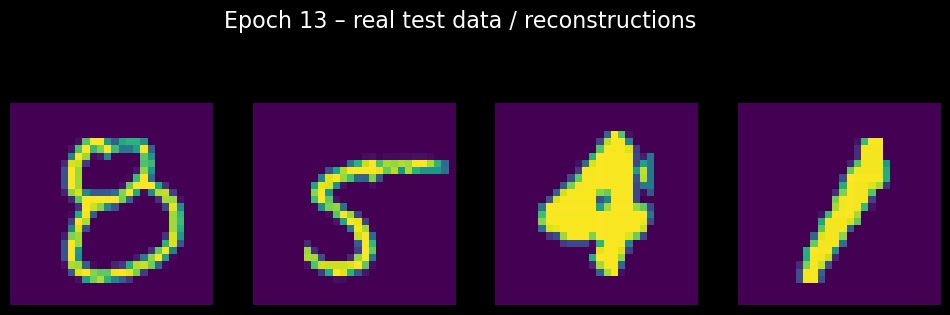

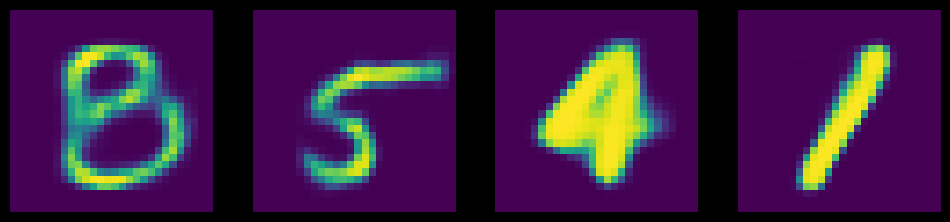

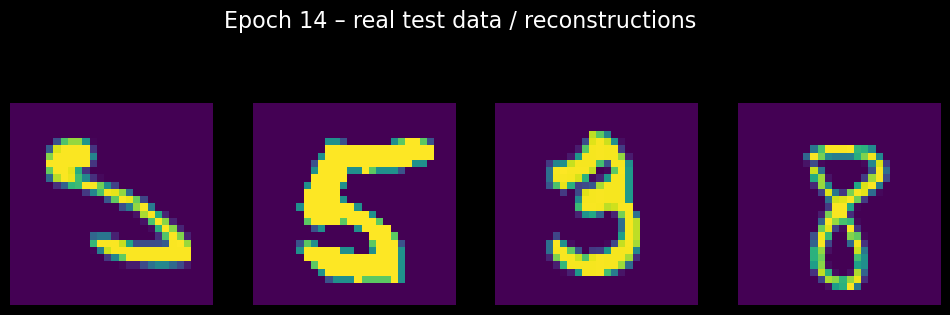

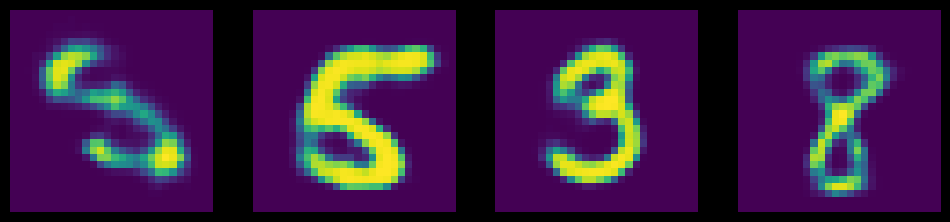

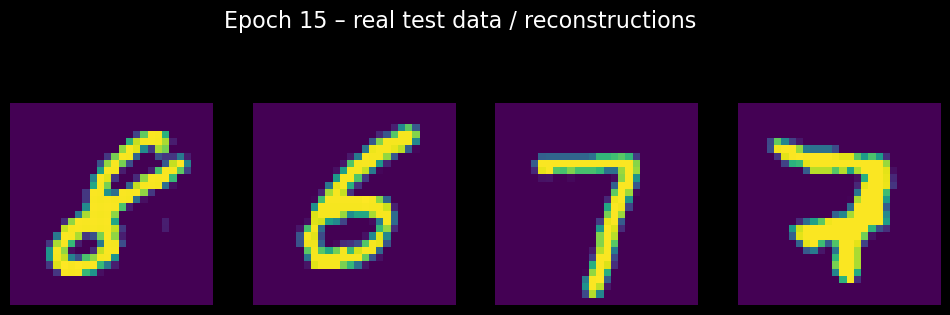

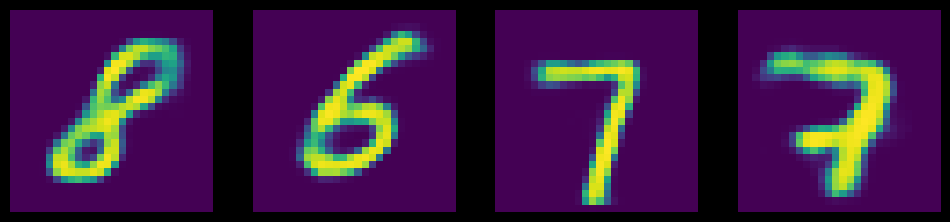

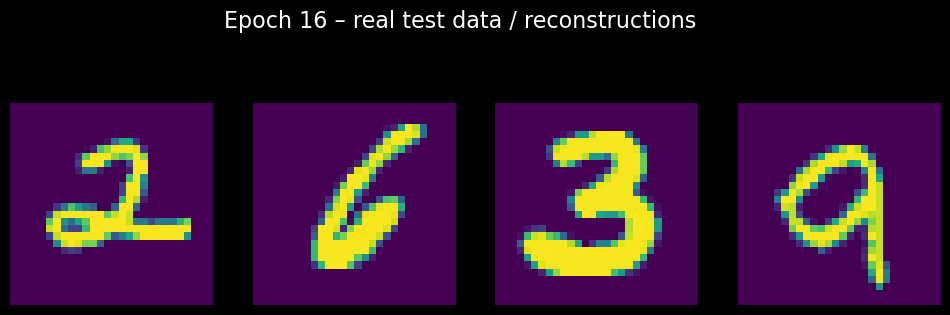

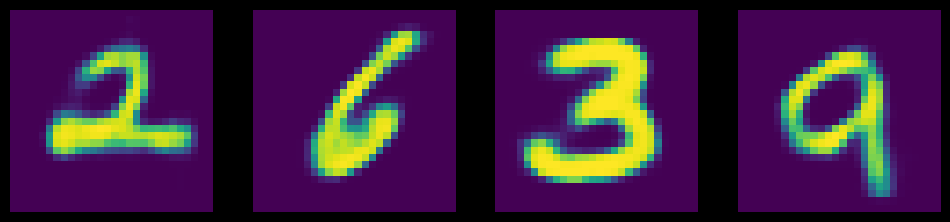

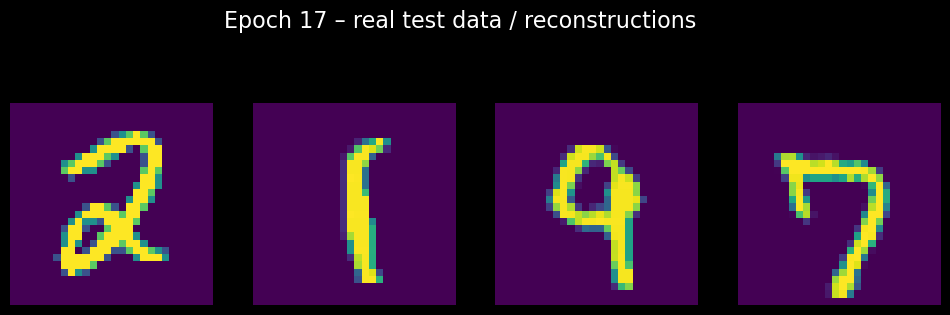

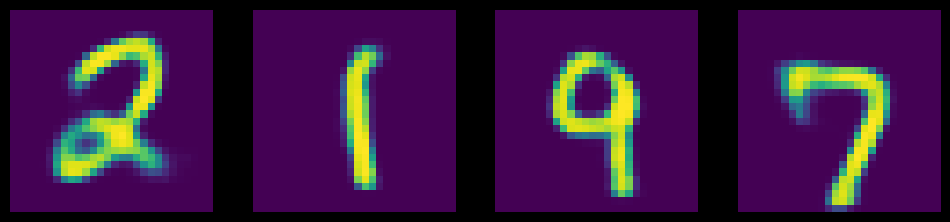

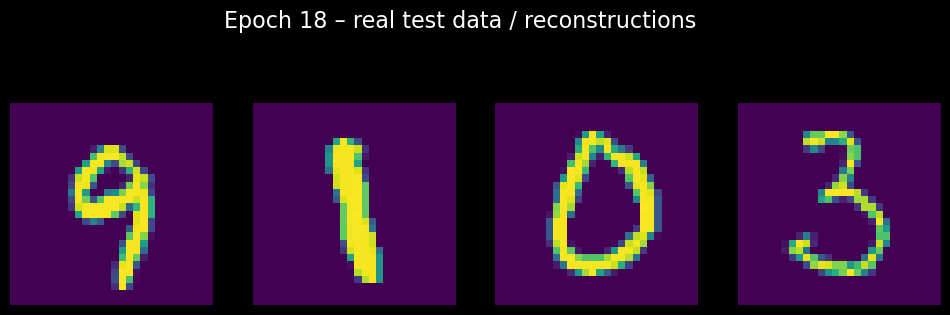

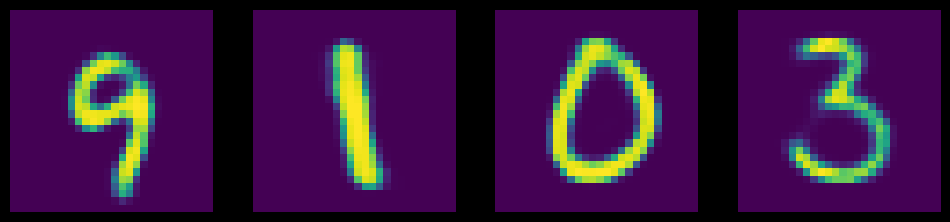

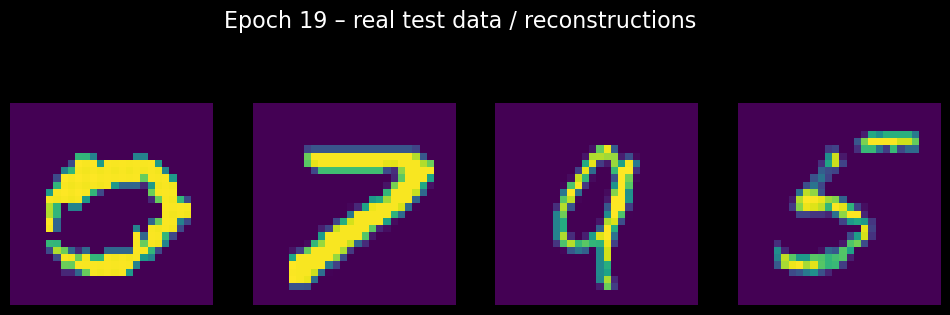

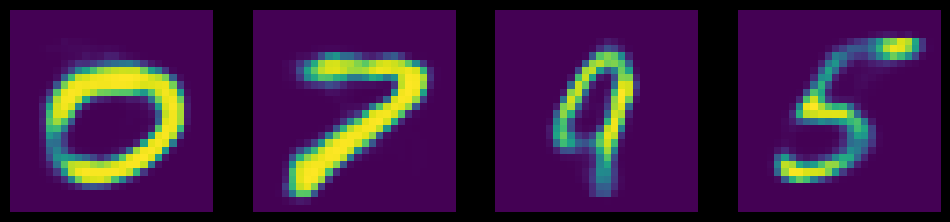

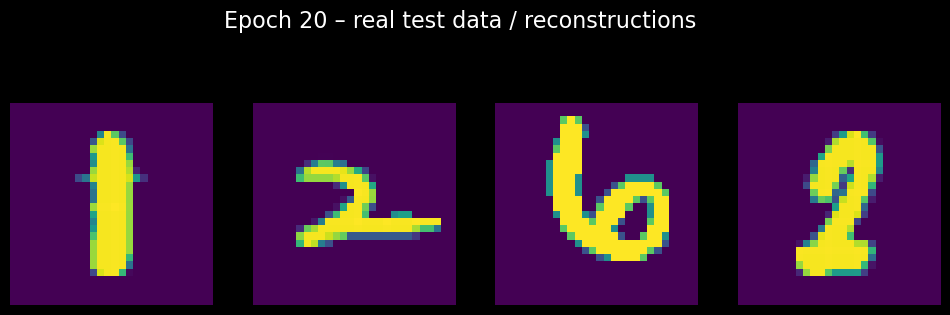

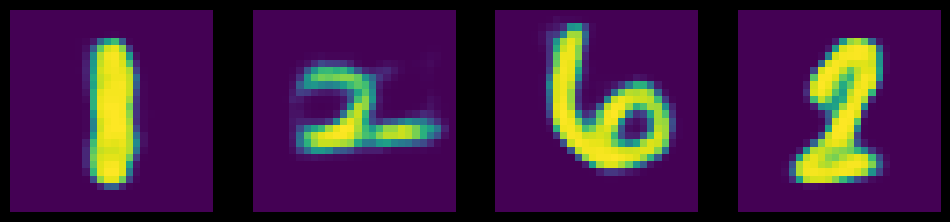

In [19]:
epochs = 20
codes = dict(μ=list(), logσ2=list(), x=list())
num = len(train_loader.dataset)
for epoch in range(0, epochs + 1):

    # Training
    if epoch > 0:  # test untrained net first
        vae.train() # pytorch functionality, we know we are in the training mode now
        t0 = time()
        train_bce_loss, train_kld_loss = 0, 0
        for y, _ in train_loader:
            y = y.to(device)
            # ===================forward=====================
            y_tilda, mu, logvar = vae(y)
            bce_loss, kld_loss = loss_function(y_tilda, y, mu, logvar)
            train_bce_loss += bce_loss.item()
            train_kld_loss += kld_loss.item()
            loss = bce_loss + kld_loss
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        train_bce_loss /= num
        train_kld_loss /= num
        print(f'====> Epoch: {epoch} Average loss BCE: {train_bce_loss:.4f}, KLD: {train_kld_loss:.4f}, '
              f'total: {train_bce_loss + train_kld_loss:.4f}, elapsed: {time() - t0:.1f}s')

    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        vae.eval() # pytorch functionality, we know we are in the evaluation mode now
        test_bce_loss, test_kld_loss = 0, 0
        for y, x in test_loader:
            y = y.to(device)
            # ===================forward=====================
            y_tilda, mu, logvar = vae(y)
            bce_loss, kld_loss = loss_function(y_tilda, y, mu, logvar)
            test_bce_loss += bce_loss.item()
            test_kld_loss += kld_loss.item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(x.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['x'].append(torch.cat(labels))
    test_bce_loss /= len(test_loader.dataset)
    test_kld_loss /= len(test_loader.dataset)
    print(f'====> Test set loss BCE: {test_bce_loss:.4f}, KLD: {test_kld_loss:.4f}, '
          f'total: {test_bce_loss + test_kld_loss:.4f}')
    display_images(y, y_tilda, 1, f'Epoch {epoch}')

<a name="vae_generation"></a>
### Generating from Random Vectors

The generated images now more closely resemble handwritten digits. You can achieve even better results, but here, it's sufficient to note the difference.

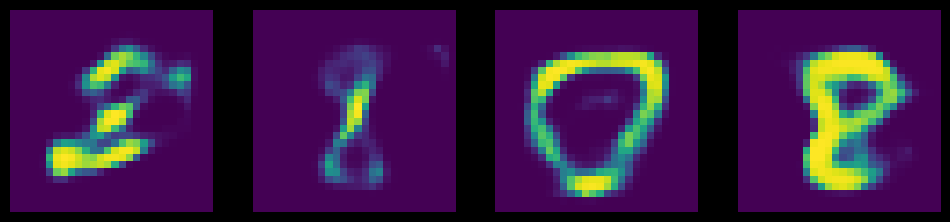

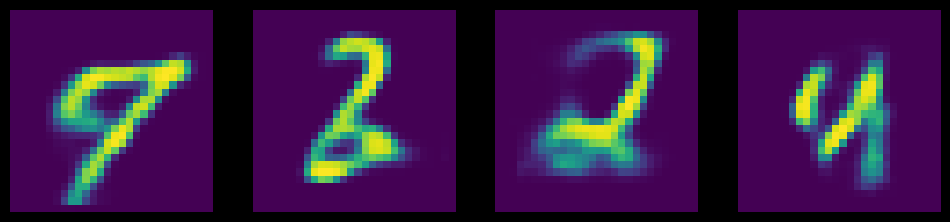

In [20]:
display_images(None, vae.decoder(torch.randn(8, d).to(device)), 2)

<a name="vae_interp"></a>
### Image Interpolation

Let's take a look at the first 8 digits from the last test batch

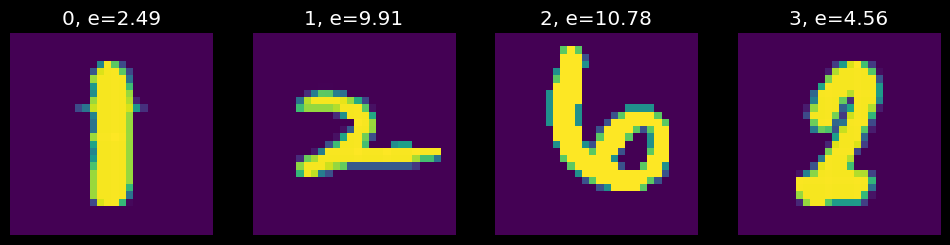

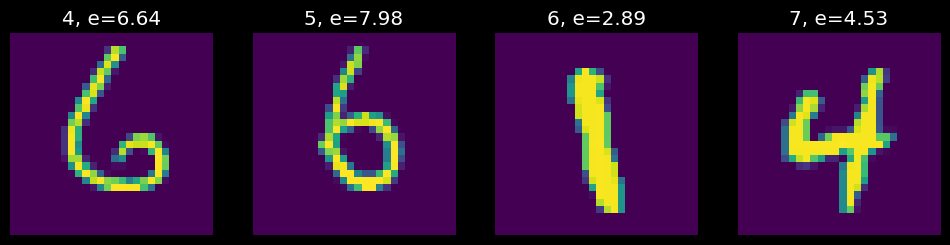

In [21]:
with torch.no_grad():
    y_tilda = vae(y)[0].view(-1, 28, 28)
energy = y.squeeze().sub(y_tilda).pow(2).sum(dim=(1,2))
display_images(None, y, 2, count=True, energy=energy)

We'll select the starting and ending points for interpolation (indices 0 and 5) and examine:

* The original and reconstructed images.
* The reconstructed images and the difference from the originals.

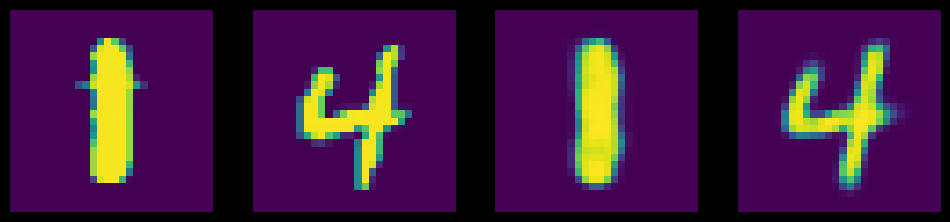

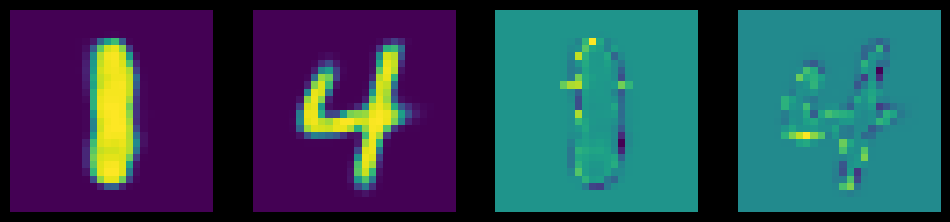

In [22]:
A, B = 0, 7
sample = vae.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    y[A].data.view(-1),
    y[B].data.view(-1),
    sample.data[0],
    sample.data[1],
    sample.data[0],
    sample.data[1],
    y[A].data.view(-1) - sample.data[0],
    y[B].data.view(-1) - sample.data[1]
)), 0), 2)

Let's perform interpolation between A and B over N steps, initially in the original space.

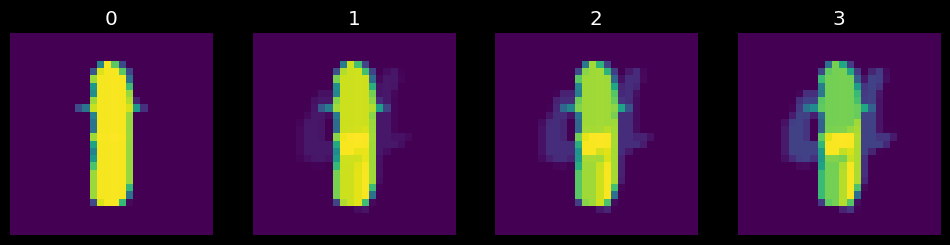

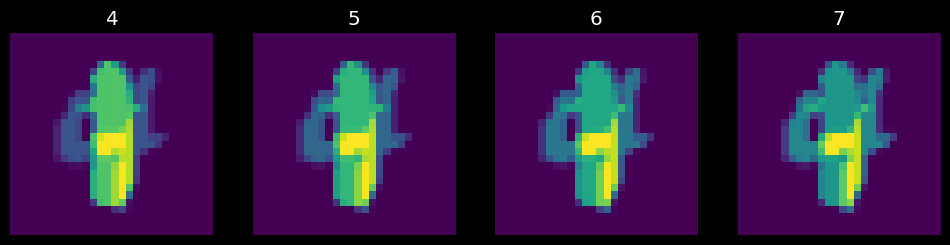

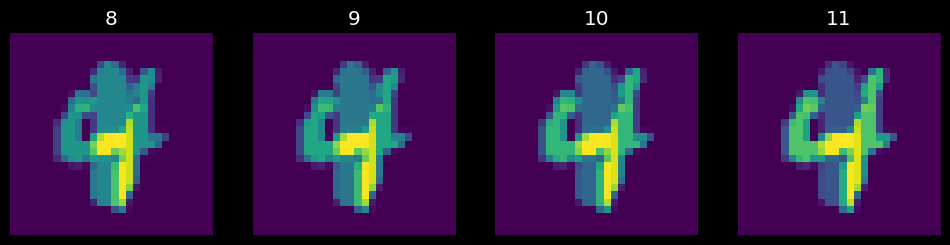

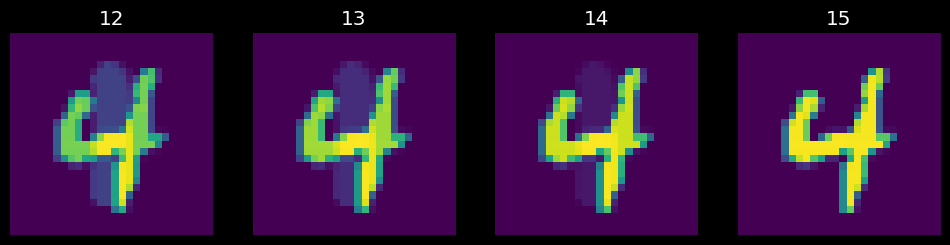

In [23]:
N = 16
# code = torch.Tensor(N, 20).to(device)
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    # code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
# samples = vae.decoder(code)
display_images(None, samples, N // 4, count=True)

Then in the latent space.

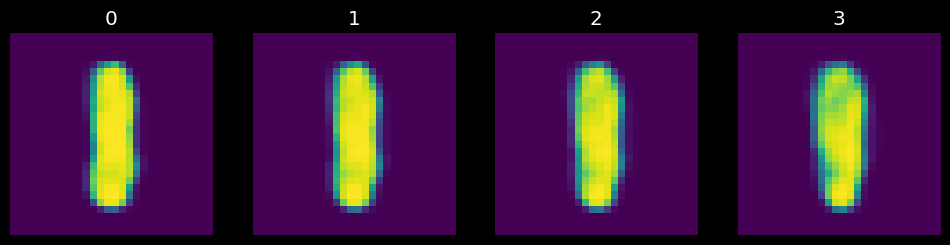

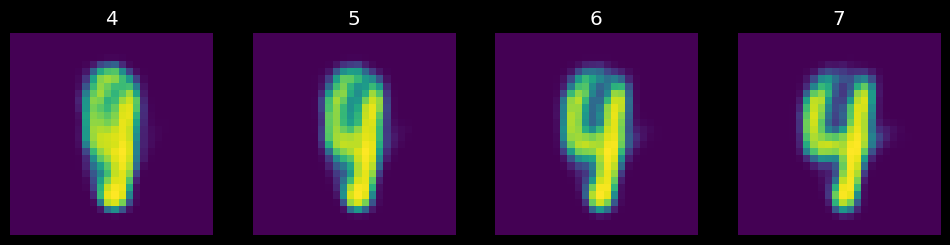

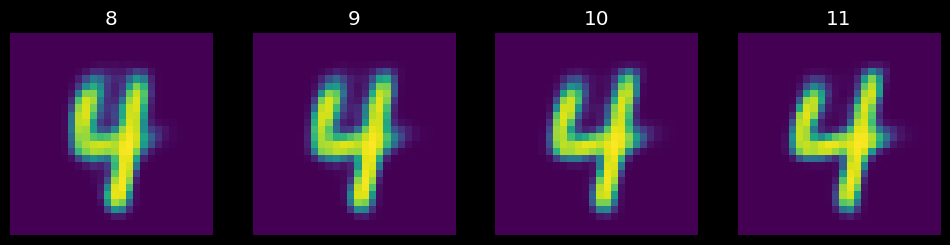

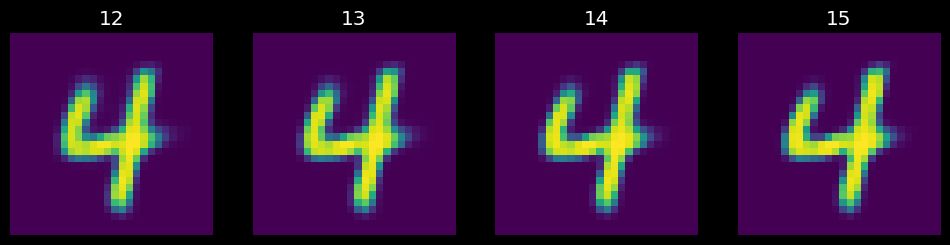

In [24]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
# samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
samples = vae.decoder(code)
display_images(None, samples, N // 4, count=True)

Let's take the average of images A and B (well, almost the average - index 9 in the array of 16) and input it into the model as an image, resulting in this interesting construction

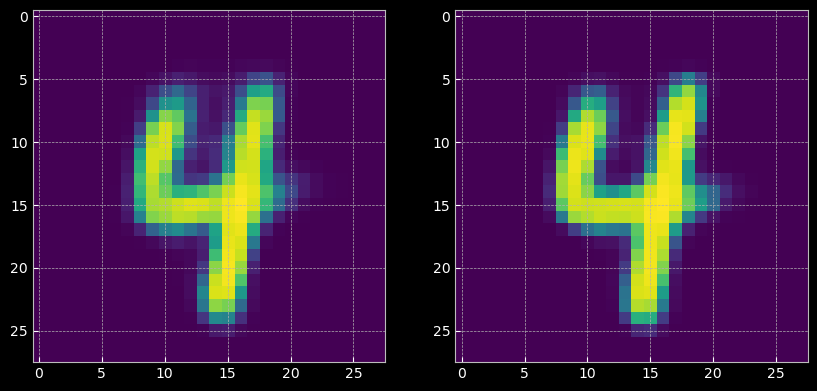

In [25]:
y_dot = samples[9]
with torch.no_grad():
    y_tilda = vae(y_dot)[0]
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow((y_dot.cpu().detach()).view(28, 28))
plt.subplot(122), plt.imshow((y_tilda.cpu()).view(28, 28));

Let's examine the reconstruction error for each level of image blending.

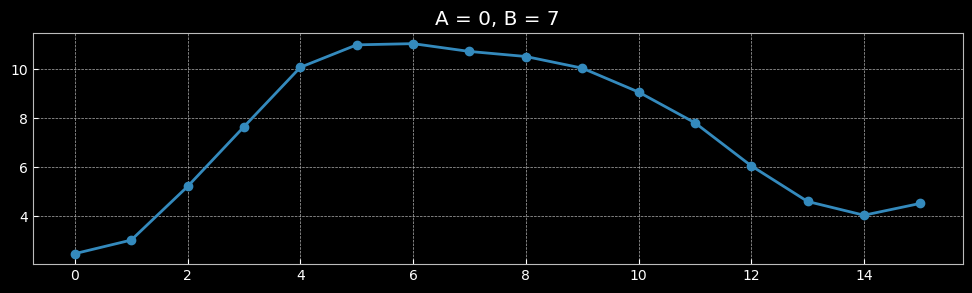

In [26]:
N = 16
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
with torch.no_grad():
    reconstructions = vae(samples)[0].view(-1, 28, 28)

plt.title(f'{A = }, {B = }')
plt.plot(samples.sub(reconstructions).pow(2).sum(dim=(1,2)).cpu(), '-o');

<a name="vae_tsne"></a>
### VAE Embeddings Visualization

For debugging in deep learning, visualization is often used, allowing us to visually assess how well the results match expectations.

Digits are color-coded, and we can see that with each epoch, there is clearer separation between digit clusters, along with increased density.

In [27]:
import numpy as np
from sklearn.manifold import TSNE

In [28]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    Y.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(Y[-1].detach().cpu()))
    X.append(codes['x'][epoch][:N])

/Users/user/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


/var/folders/lm/jstl07v96jgg_zyfm1kf06ch0000gn/T/ipykernel_64889/2546404210.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)


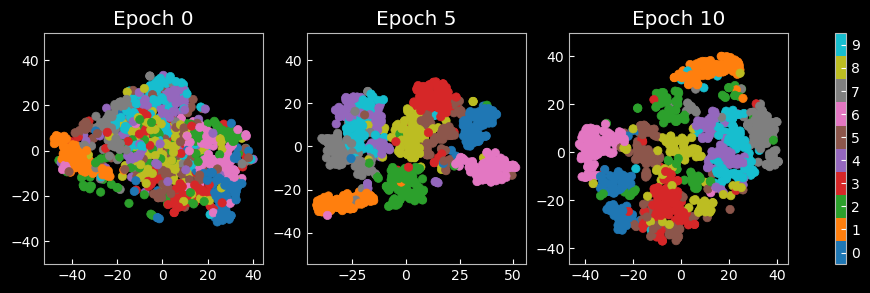

In [29]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=X[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)